# QMF Project - COVID-19 World Population Gap Analysis

## SARIMAX PART

We see in the SARIMA part that we don't manage to forecast accurately the population of China during the COVID.

Hence, the goal is to see if the use of exogeneous such as mortality rate, life expectancyn birth rate... data to forecast the china population help to forecast more precisely the china population during the COVID period

### Import libs

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# stats libs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir('C:/Users/humic/OneDrive/Documents/Ecole/SorbonneFTD/Cours/Quantitative_Method_Finance/project/data')

### Utils functions

In [3]:
def import_exog_data(path):
    # Read the Excel file skipping the first 3 rows
    df = pd.read_excel(path, skiprows=3)

    # Transpose the DataFrame to switch rows and columns
    df = df.transpose()

    # Set the first column as the index and convert it to datetime
    df.index = pd.to_datetime(df.index, errors='coerce')

    df.columns = df.iloc[0]

    # Drop the first row (original header row)
    df = df[4:]

    df.index.name = 'year'

    # Display the resulting DataFrame
    return df

def plot_pop_series(df):
    # Create a subplot for each column
    rolling_mean = df.rolling(window = 12).mean()
    rolling_std = df.rolling(window = 12).std()
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 10 * len(df.columns)))

    # Plot each column on a separate subplot
    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column])
        axes[i].set_ylabel(column, fontsize=20)
        axes[i].set_xlabel('Year', fontsize=20)
        axes[i].grid()

    print("Montly Evolution of Population (in millions)")
    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()
    
def plot_acf_pacf_non_seasonal(series):
    # Plot ACF and PACF for each time series
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 20))

    for i, col in enumerate(series.columns):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        # Plot ACF
        plot_acf(series[col], lags=10, ax=ax1, zero=False)
        ax1.set_title(f'ACF - {col}')

        # Plot PACF
        plot_pacf(series[col], lags=10, ax=ax2, zero=False)
        ax2.set_title(f'PACF - {col}')
        
def plot_series(df):
    # Create a subplot for each column
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 10 * len(df.columns)))

    # Plot each column on a separate subplot
    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column])
        axes[i].set_ylabel(column, fontsize=20)
        axes[i].set_xlabel('Year', fontsize=20)
        axes[i].grid()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()
    
    
def adf_test(series):
    """
    ADFULLER Parameter
    -'c' : constant only (default) (random-walk with a drift)
    -'ct' : constant and trend. (both series could have been trend stationary)
    -'ctt' : constant, and linear and quadratic trend.
    -'n' : no constant, no trend (random walk)
    For example:
    - imposing 'n' to regression mean that we assume a random walk
    - imposing 'c' means you assume a random walk with a drift
    """
          
    ## ADF test  ##
    result = adfuller(series, regression='ct')  # 'ct' for a constant and trend terms
    # Extract ADF test statistics and p-value
    p_value = result[1]
    print("p_value: ", p_value)
    if p_value <= 0.05:
        print("Reject the null hypothesis. The time series is likely stationary.")
    else:
        print("Fail to reject the null hypothesis. The time series may be non-stationary.")

    
def get_stationarity(timeseries):
    plt.figure(figsize=(12, 8))
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moving Average')
    std = plt.plot(rolling_std, color='black', label='Moving standard deviation')
    plt.legend(loc='best')
    plt.title("Stationarity Test")
    plt.show(block=False)
    
    adf_test(timeseries)
    
def check_corr_resid(serie, order):
    
    model = ARIMA(serie, order=order)
    results = model.fit()

    # Get the residuals
    residuals = results.resid

    # Print the mean of the residuals
    mean_residuals = np.mean(residuals)
    print(f"Mean of Residuals: {mean_residuals}")

    # Perform the Ljung-Box test
    df = acorr_ljungbox(residuals, lags=3, return_df=True)
    
    if any(df["lb_pvalue"]<0.05):
        print("We reject H0 and accept H1:The residuals are not independently distributed")
        print("Serial correlation detected in residuals.")
    else:
        print("We fail to reject H0: The residuals are not independently distributed.")
        print("No significant serial correlation in residuals.")
        
    results.plot_diagnostics()
    plt.show()
    
    return df

### Import data

#### Import world data population

In [4]:
annualy_world_population = import_exog_data("world_data_population.xls")
annualy_world_population = annualy_world_population["World"]
annualy_world_population = pd.DataFrame(annualy_world_population)

In [5]:
annualy_world_population

World
year                    
1960-01-01  3031474234.0
1961-01-01  3072421801.0
1962-01-01  3126849612.0
1963-01-01  3193428894.0
1964-01-01  3260441925.0
...                  ...
2018-01-01  7661776612.0
2019-01-01  7742682218.0
2020-01-01  7820963775.0
2021-01-01  7888161297.0
2022-01-01  7951149546.0

[63 rows x 1 columns]

In [6]:
# Display rows with NaN values
rows_with_nan = annualy_world_population[annualy_world_population.isnull().any(axis=1)]
rows_with_nan

Empty DataFrame
Columns: [World]
Index: []

In [7]:
annualy_world_population_raw = annualy_world_population.copy()
annualy_world_population_covid = annualy_world_population[-4:]
annualy_world_population = annualy_world_population[:-3]

#### Import data population

In [8]:
monthly_pop_data = pd.read_excel("monthly_population.xlsx", skiprows=6)
monthly_pop_data = monthly_pop_data.iloc[:-2,:] # ignore the footer of the file

# save the name of column into a list
col_list = monthly_pop_data["Unnamed: 0"].tolist()

# ignore the columns
monthly_pop_data = monthly_pop_data.iloc[:, 1:]

# transpose the dataframe
monthly_pop_data = monthly_pop_data.transpose()

# rename the dataframe
monthly_pop_data.columns = col_list

# convert to datetime the index of the dataframe
monthly_pop_data.index = pd.to_datetime(monthly_pop_data.index, format='%m/%Y')
monthly_pop_data

World Total Countries Albania Algeria  Argentina Australia  \
2023-10-01           -         -       -       -   46.60956         -   
2023-09-01           -         -       -       -   46.60956         -   
2023-08-01           -         -       -       -   46.60956         -   
2023-07-01           -         -       -       -   46.60956         -   
2023-06-01           -         -       -       -   46.60956         -   
...                ...       ...     ...     ...        ...       ...   
1994-03-01           -         -       -  27.496  34.846916   17.7721   
1994-02-01           -         -       -  27.496  34.846916   17.7721   
1994-01-01           -         -       -  27.496  34.846916   17.7721   
1993-12-01           -         -       -  26.894  34.407177   17.7191   
1993-11-01           -         -       -  26.894  34.407177   17.7191   

             Austria Azerbaijan   Bahrain  Bangladesh  ...  \
2023-10-01  9.104772  10.420515         -           -  ...   
2023-09-01  9.104772  10.420515         -           -  ...   
2023-08-01  9.104772  10.420515         -           -  ...   
2023-07-01  9.104772  10.420515         -           -  ...   
2023-06-01  9.104772  10.420515         -           -  ...   
...              ...        ...       ...         ...  ...   
1994-03-01  7.928746   7.952142  0.544366  112.737686  ...   
1994-02-01  7.928746   7.952142  0.544366  112.737686  ...   
1994-01-01  7.928746   7.952142  0.544366  112.737686  ...   
1993-12-01  7.882519   7.839115  0.530225   110.35064  ...   
1993-11-01  7.882519   7.839115  0.530225   110.35064  ...   

           United Arab Emirates United Kingdom United States   Uruguay  \
2023-10-01                    -              -     339.66513  3.416264   
2023-09-01                    -              -     339.66513  3.416264   
2023-08-01                    -              -     339.66513  3.416264   
2023-07-01                    -              -     339.66513  3.416264   
2023-06-01                    -              -     339.66513  3.416264   
...                         ...            ...           ...       ...   
1994-03-01                2.217        57.8621     263.12582  3.137032   
1994-02-01                2.217        57.8621     263.12582  3.137032   
1994-01-01                2.217        57.8621     263.12582  3.137032   
1993-12-01                2.097        57.7139      259.9186  3.123831   
1993-11-01                2.097        57.7139      259.9186  3.123831   

           Uzbekistan  Venezuela  Vietnam      Yemen     Zambia Zimbabwe  
2023-10-01  31.360836  33.728622        -          -  19.464165        -  
2023-09-01  31.360836  33.728622        -          -  19.464165        -  
2023-08-01  31.360836  33.728622        -          -  19.464165        -  
2023-07-01  31.360836  33.728622        -          -  19.464165        -  
2023-06-01  31.360836  33.728622        -          -  19.464165        -  
...               ...        ...      ...        ...        ...      ...  
1994-03-01  22.603815  21.582756  70.8245  14.297617          -     11.1  
1994-02-01  22.603815  21.582756  70.8245  14.297617          -     11.1  
1994-01-01  22.603815  21.582756  70.8245  14.297617          -     11.1  
1993-12-01  22.127596  21.121216  69.6445  13.634082          -     10.8  
1993-11-01  22.127596  21.121216  69.6445  13.634082          -     10.8  

[360 rows x 106 columns]

In [9]:
# Select the countries we want to study
monthly_pop_data = monthly_pop_data[["Argentina", "China", "France", "New Zealand", "Norway"]]
monthly_pop_data = monthly_pop_data.replace('-', np.nan)
monthly_pop_data.index.name = "Month"

# Sort index
monthly_pop_data = monthly_pop_data.sort_index(ascending=True)
monthly_pop_data

Argentina    China  France  New Zealand    Norway
Month                                                        
1993-11-01  34.407177  1185.17     NaN       3.5978  4.299167
1993-12-01  34.407177  1185.17     NaN       3.5978  4.299167
1994-01-01  34.846916  1198.50  59.070       3.6115  4.324815
1994-02-01  34.846916  1198.50  59.078       3.6115  4.324815
1994-03-01  34.846916  1198.50  59.090       3.6115  4.324815
...               ...      ...     ...          ...       ...
2023-06-01  46.609560      NaN  68.113       5.2231  5.488984
2023-07-01  46.609560      NaN  68.136          NaN  5.488984
2023-08-01  46.609560      NaN  68.161          NaN  5.488984
2023-09-01  46.609560      NaN  68.184          NaN  5.488984
2023-10-01  46.609560      NaN     NaN          NaN  5.488984

[360 rows x 5 columns]

In [10]:
# Display rows with NaN values
rows_with_nan = monthly_pop_data[monthly_pop_data.isnull().any(axis=1)]
rows_with_nan

Argentina    China  France  New Zealand    Norway
Month                                                        
1993-11-01  34.407177  1185.17     NaN       3.5978  4.299167
1993-12-01  34.407177  1185.17     NaN       3.5978  4.299167
2023-01-01  46.609560      NaN  68.043       5.1982  5.488984
2023-02-01  46.609560      NaN  68.049       5.1982  5.488984
2023-03-01  46.609560      NaN  68.063       5.1982  5.488984
2023-04-01  46.609560      NaN  68.078       5.2231  5.488984
2023-05-01  46.609560      NaN  68.094       5.2231  5.488984
2023-06-01  46.609560      NaN  68.113       5.2231  5.488984
2023-07-01  46.609560      NaN  68.136          NaN  5.488984
2023-08-01  46.609560      NaN  68.161          NaN  5.488984
2023-09-01  46.609560      NaN  68.184          NaN  5.488984
2023-10-01  46.609560      NaN     NaN          NaN  5.488984

### Deal with `NaN`   

Fill `NaN` values with the previous value (forward fill)

Since we're dealing with monthly data, births from one month to the next don't change much, so we choose to fill in the NaN value with the previous value.

However, when the previous value is a NaN value (i.e. several consecutive NaN values), the NaN value remains unchanged.

In [11]:
# Fill NaN values with the previous value (forward fill)
monthly_pop_data.fillna(method='ffill', inplace=True)

### Check for remains `NaN` values   

In [12]:
rows_with_nan_bis = monthly_pop_data[monthly_pop_data.isnull().any(axis=1)]
rows_with_nan_bis

Argentina    China  France  New Zealand    Norway
Month                                                        
1993-11-01  34.407177  1185.17     NaN       3.5978  4.299167
1993-12-01  34.407177  1185.17     NaN       3.5978  4.299167

You can see that there's not much `NaN` value left. What's more, most of these values concern the year 2023, which is of no interest to us for our study, as we wish to predict the population beyond March 2020 (the month in which COVID makes its appearance).

In [13]:
monthly_pop_data.dropna()
monthly_pop_data

Argentina    China  France  New Zealand    Norway
Month                                                        
1993-11-01  34.407177  1185.17     NaN       3.5978  4.299167
1993-12-01  34.407177  1185.17     NaN       3.5978  4.299167
1994-01-01  34.846916  1198.50  59.070       3.6115  4.324815
1994-02-01  34.846916  1198.50  59.078       3.6115  4.324815
1994-03-01  34.846916  1198.50  59.090       3.6115  4.324815
...               ...      ...     ...          ...       ...
2023-06-01  46.609560  1411.75  68.113       5.2231  5.488984
2023-07-01  46.609560  1411.75  68.136       5.2231  5.488984
2023-08-01  46.609560  1411.75  68.161       5.2231  5.488984
2023-09-01  46.609560  1411.75  68.184       5.2231  5.488984
2023-10-01  46.609560  1411.75  68.184       5.2231  5.488984

[360 rows x 5 columns]

#### Resample the population series as annualy time series

We have to resample our time series because our exogeneous have a annualy frequency.

In [14]:
annualy_pop_data = monthly_pop_data.resample('A').mean()
annualy_pop_data_raw = annualy_pop_data.copy()
annualy_pop_data

Argentina    China     France  New Zealand    Norway
Month                                                           
1993-12-31  34.407177  1185.17        NaN     3.597800  4.299167
1994-12-31  34.846916  1198.50  59.158750     3.627900  4.324815
1995-12-31  35.273870  1211.21  59.369250     3.683100  4.348410
1996-12-31  35.682983  1223.89  59.573750     3.740825  4.369959
1997-12-31  36.102184  1236.26  59.775917     3.787625  4.392714
1998-12-31  36.517940  1247.61  59.992667     3.819100  4.417599
1999-12-31  36.923440  1257.86  60.289167     3.840075  4.445329
2000-12-31  37.335674  1267.43  60.694500     3.862900  4.478497
2001-12-31  37.739190  1276.27  61.141583     3.892075  4.503436
2002-12-31  38.131973  1284.53  61.575333     3.960325  4.524066
2003-12-31  38.529400  1292.27  62.016500     4.036675  4.552252
2004-12-31  38.945350  1299.88  62.460167     4.095275  4.577457
2005-12-31  39.367280  1307.56  62.926250     4.141850  4.606363
2006-12-31  39.761784  1314.48  63.366500     4.191325  4.640219
2007-12-31  40.134010  1321.29  63.760250     4.230800  4.681134
2008-12-31  40.531410  1328.02  64.112250     4.266325  4.737171
2009-12-31  40.943943  1334.50  64.432583     4.311375  4.799252
2010-12-31  41.358093  1340.91  64.752667     4.358250  4.858199
2011-12-31  41.791720  1349.16  65.067417     4.389475  4.920305
2012-12-31  42.216145  1359.22  65.378167     4.414025  4.985870
2013-12-31  42.635450  1367.26  65.706667     4.453350  5.051275
2014-12-31  43.057446  1376.46  66.260667     4.530575  5.109056
2015-12-31  43.474730  1383.26  66.491083     4.625325  5.165802
2016-12-31  43.886750  1392.32  66.677667     4.729475  5.213985
2017-12-31  44.293293  1400.11  66.861833     4.826525  5.258317
2018-12-31  44.694200  1405.41  67.099167     4.912300  5.295619
2019-12-31  45.089493  1410.08  67.330500     4.997950  5.328212
2020-12-31  45.479120  1412.12  67.532417     5.093850  5.367580
2021-12-31  45.862620  1412.60  67.712500     5.112675  5.391369
2022-12-31  46.239388  1411.75  67.929917     5.129850  5.425270
2023-12-31  46.609560  1411.75  68.110500     5.215630  5.488984

#### Plot the evolution of population for each country

Montly Evolution of Population (in millions)


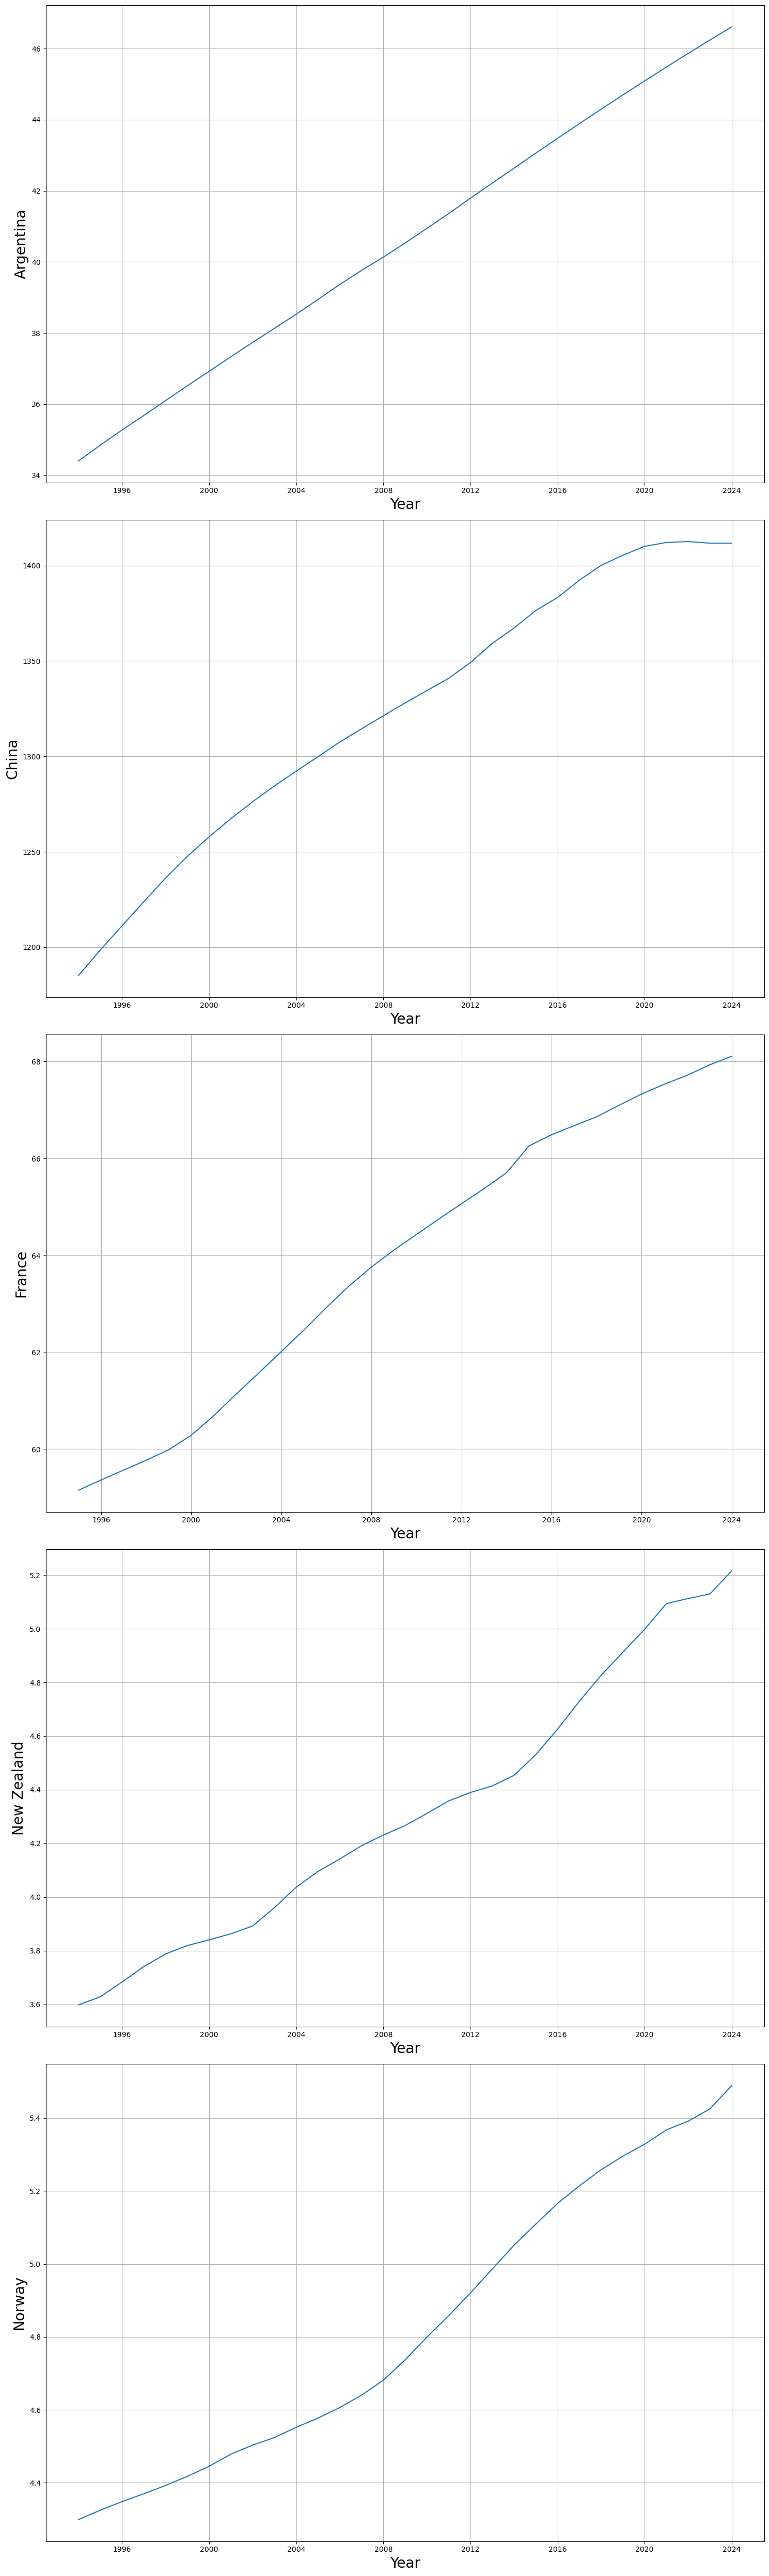

In [15]:
plot_pop_series(annualy_pop_data)

After resampling the time series in anuality frequency, we remove the seasonality of the time series as we see during the SARIMA Part.

We can see that our series have a positive trend. We will have to remove this positive trend in order to make the series stationary

### Split the population data according covid and non-covid period

In [16]:
annualy_pop_data_covid = annualy_pop_data.iloc[-5:,:]
annualy_pop_data_covid

Argentina    China     France  New Zealand    Norway
Month                                                           
2019-12-31  45.089493  1410.08  67.330500     4.997950  5.328212
2020-12-31  45.479120  1412.12  67.532417     5.093850  5.367580
2021-12-31  45.862620  1412.60  67.712500     5.112675  5.391369
2022-12-31  46.239388  1411.75  67.929917     5.129850  5.425270
2023-12-31  46.609560  1411.75  68.110500     5.215630  5.488984

In [17]:
annualy_pop_data = annualy_pop_data.iloc[:-4,:]
annualy_pop_data

Argentina    China     France  New Zealand    Norway
Month                                                           
1993-12-31  34.407177  1185.17        NaN     3.597800  4.299167
1994-12-31  34.846916  1198.50  59.158750     3.627900  4.324815
1995-12-31  35.273870  1211.21  59.369250     3.683100  4.348410
1996-12-31  35.682983  1223.89  59.573750     3.740825  4.369959
1997-12-31  36.102184  1236.26  59.775917     3.787625  4.392714
1998-12-31  36.517940  1247.61  59.992667     3.819100  4.417599
1999-12-31  36.923440  1257.86  60.289167     3.840075  4.445329
2000-12-31  37.335674  1267.43  60.694500     3.862900  4.478497
2001-12-31  37.739190  1276.27  61.141583     3.892075  4.503436
2002-12-31  38.131973  1284.53  61.575333     3.960325  4.524066
2003-12-31  38.529400  1292.27  62.016500     4.036675  4.552252
2004-12-31  38.945350  1299.88  62.460167     4.095275  4.577457
2005-12-31  39.367280  1307.56  62.926250     4.141850  4.606363
2006-12-31  39.761784  1314.48  63.366500     4.191325  4.640219
2007-12-31  40.134010  1321.29  63.760250     4.230800  4.681134
2008-12-31  40.531410  1328.02  64.112250     4.266325  4.737171
2009-12-31  40.943943  1334.50  64.432583     4.311375  4.799252
2010-12-31  41.358093  1340.91  64.752667     4.358250  4.858199
2011-12-31  41.791720  1349.16  65.067417     4.389475  4.920305
2012-12-31  42.216145  1359.22  65.378167     4.414025  4.985870
2013-12-31  42.635450  1367.26  65.706667     4.453350  5.051275
2014-12-31  43.057446  1376.46  66.260667     4.530575  5.109056
2015-12-31  43.474730  1383.26  66.491083     4.625325  5.165802
2016-12-31  43.886750  1392.32  66.677667     4.729475  5.213985
2017-12-31  44.293293  1400.11  66.861833     4.826525  5.258317
2018-12-31  44.694200  1405.41  67.099167     4.912300  5.295619
2019-12-31  45.089493  1410.08  67.330500     4.997950  5.328212

#### Import annual Birth rate data

In [18]:
birth_rate = import_exog_data("birth_rate.xls")
birth_rate

NaT          Aruba Africa Eastern and Southern Afghanistan  \
year                                                         
1960-01-01  33.883                   47.438554       50.34   
1961-01-01  32.831                   47.530552      50.443   
1962-01-01  31.649                   47.597558       50.57   
1963-01-01  30.416                    47.63614      50.703   
1964-01-01  29.147                    47.64548      50.831   
...            ...                         ...         ...   
2018-01-01   9.881                   34.611022      36.927   
2019-01-01   9.138                    34.34145      36.466   
2020-01-01   8.102                   33.916746      36.051   
2021-01-01   7.193                   33.546266      35.842   
2022-01-01     NaN                         NaN         NaN   

NaT        Africa Western and Central  Angola Albania Andorra Arab World  \
year                                                                       
1960-01-01                  47.325476  51.026  41.068     NaN  47.609965   
1961-01-01                  47.421051  51.282  40.332     NaN  47.565064   
1962-01-01                  47.529223  51.316  39.216     NaN  47.942592   
1963-01-01                  47.531029  51.323  38.149     NaN  47.641484   
1964-01-01                  47.511923  51.282  36.825     NaN  47.348272   
...                               ...     ...     ...     ...        ...   
2018-01-01                  37.447087  40.236  10.517     7.2  25.102987   
2019-01-01                  37.027834  39.725  10.343     7.0   24.59862   
2020-01-01                   36.61573  39.271  10.285     NaN  24.234483   
2021-01-01                  36.237034  38.809   10.24     NaN  23.774833   
2022-01-01                        NaN     NaN     NaN     NaN        NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01               41.814    23.784  ...                  35.0   41.331   
1961-01-01               41.392    23.638  ...                 34.62   35.609   
1962-01-01               41.062    23.798  ...                 34.24     39.8   
1963-01-01               40.601    23.663  ...                 33.86   39.719   
1964-01-01               40.003    23.437  ...                 33.48   38.366   
...                         ...       ...  ...                   ...      ...   
2018-01-01               10.049    15.187  ...                  12.6   15.873   
2019-01-01                 9.75    14.783  ...                  12.3   15.663   
2020-01-01                10.62    14.125  ...                  12.1     15.4   
2021-01-01               10.307    13.902  ...                  11.8   15.008   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT        Vanuatu      World   Samoa  Kosovo Yemen, Rep. South Africa  \
year                                                                     
1960-01-01  44.677   31.90838  48.065  41.129      54.408        39.52   
1961-01-01  44.604  31.165343  47.322  40.947      54.704       39.911   
1962-01-01  44.466  35.103311  46.558  40.708      54.784       39.963   
1963-01-01  44.292   36.27461  45.656   40.43      54.943       40.028   
1964-01-01  44.076  35.131802  44.876  39.515      55.318       40.072   
...            ...        ...     ...     ...         ...          ...   
2018-01-01  30.889  18.178494  28.222  12.094      32.305       21.137   
2019-01-01    30.4  17.817433  27.895  11.443      31.778       21.276   
2020-01-01  29.939  17.226396  27.622  11.181      31.252       20.326   
2021-01-01  29.438  16.939073  27.254  11.143      30.544       19.821   
2022-01-01     NaN        NaN     NaN     NaN         NaN          NaN   

NaT         Zambia Zimbabwe  
year                         
1960-01-01  49.929    47.26  
1961-01-01  50.026   47.039  
1962-01-01  50.064   46.867  
1963-01-01  50.037   46.611  
1964-01

#### Check for NaN values

In [19]:
# Select the countries we want to study
birth_rate = birth_rate[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = birth_rate[birth_rate.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [20]:
#birth_rate.dropna(inplace=True)
birth_rate = birth_rate.rename(columns=lambda x: x + '_birth_rate')
birth_rate

NaT        Argentina_birth_rate China_birth_rate France_birth_rate  \
year                                                                 
1960-01-01               23.784            20.86              18.7   
1961-01-01               23.638            18.02              18.7   
1962-01-01               23.798            37.01              18.6   
1963-01-01               23.663            43.37              18.5   
1964-01-01               23.437            39.14              18.4   
...                         ...              ...               ...   
2018-01-01               15.187            10.86              11.3   
2019-01-01               14.783            10.41              11.2   
2020-01-01               14.125             8.52              10.9   
2021-01-01               13.902             7.52              10.9   
2022-01-01                  NaN              NaN               NaN   

NaT        New Zealand_birth_rate Norway_birth_rate  
year                                                 
1960-01-01                   26.5              17.3  
1961-01-01                   27.1              17.3  
1962-01-01                   26.2              17.1  
1963-01-01                   25.5              17.3  
1964-01-01                   24.2              17.7  
...                           ...               ...  
2018-01-01                  11.84              10.4  
2019-01-01                  11.96              10.2  
2020-01-01                  11.32               9.8  
2021-01-01                  11.48              10.4  
2022-01-01                    NaN               NaN  

[63 rows x 5 columns]

#### Annual death rate

In [21]:
death_rate = import_exog_data("death_rate.xls")
death_rate

NaT          Aruba Africa Eastern and Southern Afghanistan  \
year                                                         
1960-01-01   6.594                   20.918108      31.921   
1961-01-01   6.456                   20.681404      31.349   
1962-01-01   6.394                   20.393118      30.845   
1963-01-01   6.275                   20.254634      30.359   
1964-01-01    6.25                   19.808492      29.867   
...            ...                         ...         ...   
2018-01-01   8.597                     7.58811       6.981   
2019-01-01   8.778                    7.434644       6.791   
2020-01-01    9.69                    7.620548       7.113   
2021-01-01  11.235                    8.036899       7.344   
2022-01-01     NaN                         NaN         NaN   

NaT        Africa Western and Central  Angola Albania Andorra Arab World  \
year                                                                       
1960-01-01                  26.363067  26.659  16.681     NaN  21.183258   
1961-01-01                  26.093769  27.483  15.735     NaN  20.595564   
1962-01-01                  25.643977  27.211  14.871     NaN  20.332851   
1963-01-01                  25.373806  26.913  13.918     NaN  19.700622   
1964-01-01                  25.151359  26.582  12.993     NaN   19.02781   
...                               ...     ...     ...     ...        ...   
2018-01-01                   10.71184    7.99   8.308     4.4   5.226992   
2019-01-01                  10.488748   7.811    8.48     3.9   5.198866   
2020-01-01                  10.601297   7.821  10.785     NaN   5.616108   
2021-01-01                  10.678952   8.009  11.325     NaN   5.750367   
2022-01-01                        NaN     NaN     NaN     NaN        NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01               15.546     8.844  ...                  10.0   11.467   
1961-01-01               14.963     8.724  ...                  9.68     10.9   
1962-01-01                14.29     8.924  ...                  9.36   11.054   
1963-01-01                13.61     8.917  ...                  9.04   11.813   
1964-01-01               12.667     9.093  ...                  8.72   11.437   
...                         ...       ...  ...                   ...      ...   
2018-01-01                1.324      7.68  ...                   7.9    6.663   
2019-01-01                1.471       7.6  ...                   8.2    6.706   
2020-01-01                1.766     8.509  ...                   8.4    6.169   
2021-01-01                1.874     8.955  ...                   8.6    7.317   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT        Vanuatu      World   Samoa  Kosovo Yemen, Rep. South Africa  \
year                                                                     
1960-01-01  16.655  17.234219  12.747  10.631      33.038       14.073   
1961-01-01  16.138   14.58336  12.307  10.362      32.711        13.81   
1962-01-01  15.624  13.616548  12.008  10.134      33.206       13.617   
1963-01-01  15.102  13.459175  11.354   9.903      33.593       13.446   
1964-01-01  14.636   13.52932  12.897   9.652      32.144       13.275   
...            ...        ...     ...     ...         ...          ...   
2018-01-01   5.739   7.488643   5.297   5.505       6.629        8.765   
2019-01-01   5.663   7.471373     5.5    5.56       6.416        8.614   
2020-01-01   5.487   8.033368   5.305   7.505       6.509        9.425   
2021-01-01   5.395   8.723775   5.343    7.22       6.845       11.432   
2022-01-01     NaN        NaN     NaN     NaN         NaN          NaN   

NaT         Zambia Zimbabwe  
year                         
1960-01-01  17.285   14.221  
1961-01-01  17.019   13.919  
1962-01-01  16.789   13.585  
1963-01-01  16.558   13.235  
1964-01

In [22]:
# Select the countries we want to study
death_rate = death_rate[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = death_rate[death_rate.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [23]:
#death_rate.dropna(inplace=True)
death_rate = death_rate.rename(columns=lambda x: x + '_death_rate')
death_rate

NaT        Argentina_death_rate China_death_rate France_death_rate  \
year                                                                 
1960-01-01                8.844            25.43              11.4   
1961-01-01                8.724            14.24              11.3   
1962-01-01                8.924            10.02              11.2   
1963-01-01                8.917            10.04              11.1   
1964-01-01                9.093             11.5              11.1   
...                         ...              ...               ...   
2018-01-01                 7.68             7.08               9.1   
2019-01-01                  7.6             7.09               9.1   
2020-01-01                8.509             7.07               9.9   
2021-01-01                8.955             7.18               9.7   
2022-01-01                  NaN              NaN               NaN   

NaT        New Zealand_death_rate Norway_death_rate  
year                                                 
1960-01-01                   8.79               9.1  
1961-01-01                   8.98               9.2  
1962-01-01                   8.89               9.4  
1963-01-01                   8.84              10.0  
1964-01-01                   8.83               9.5  
...                           ...               ...  
2018-01-01                   6.78               7.7  
2019-01-01                   6.87               7.6  
2020-01-01                   6.41               7.5  
2021-01-01                   6.83               7.8  
2022-01-01                    NaN               NaN  

[63 rows x 5 columns]

#### Import fertility rate female data

In [24]:
fertility_rate_female = import_exog_data("fertility_rate_female.xls")
fertility_rate_female

NaT         Aruba Africa Eastern and Southern Afghanistan  \
year                                                        
1960-01-01   4.82                    6.724125       7.282   
1961-01-01  4.655                    6.742752       7.284   
1962-01-01  4.471                     6.76293       7.292   
1963-01-01  4.271                    6.778712       7.302   
1964-01-01  4.059                     6.78842       7.304   
...           ...                         ...         ...   
2018-01-01  1.587                    4.527705       5.002   
2019-01-01  1.486                    4.482898        4.87   
2020-01-01  1.325                      4.4169        4.75   
2021-01-01   1.18                    4.354709       4.643   
2022-01-01    NaN                         NaN         NaN   

NaT        Africa Western and Central Angola Albania Andorra Arab World  \
year                                                                      
1960-01-01                   6.458448  6.708   6.455     NaN   6.934332   
1961-01-01                   6.471518   6.79   6.353     NaN   6.982115   
1962-01-01                   6.491826  6.872   6.207     NaN   7.076112   
1963-01-01                   6.506088  6.954   6.047     NaN   7.071542   
1964-01-01                   6.525355  7.036   5.849     NaN   7.061969   
...                               ...    ...     ...     ...        ...   
2018-01-01                   5.186319  5.519    1.44     NaN   3.279994   
2019-01-01                   5.118932  5.442   1.414     NaN   3.224519   
2020-01-01                   5.049329  5.371     1.4     NaN   3.186003   
2021-01-01                   4.978662  5.304    1.39     NaN   3.142565   
2022-01-01                        NaN    NaN     NaN     NaN        NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01                6.718     3.075  ...                 5.445     6.28   
1961-01-01                6.678     3.069  ...                 4.893    5.476   
1962-01-01                6.659     3.106  ...                 4.929    6.274   
1963-01-01                6.619     3.101  ...                 4.648    6.385   
1964-01-01                6.573      3.08  ...                 5.016    6.285   
...                         ...       ...  ...                   ...      ...   
2018-01-01                1.356     2.039  ...                  2.06    1.937   
2019-01-01                1.334     1.994  ...                  2.05    1.948   
2020-01-01                 1.46     1.911  ...                  2.03    1.955   
2021-01-01                 1.46     1.885  ...                  2.01    1.944   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT        Vanuatu     World  Samoa Kosovo Yemen, Rep. South Africa Zambia  \
year                                                                         
1960-01-01   6.863  4.695854  7.646  6.359       7.938        6.159  7.115   
1961-01-01   6.818  4.575587  7.641   6.35       7.963        6.138  7.169   
1962-01-01   6.777  5.035173  7.646  6.331       7.963         6.11  7.214   
1963-01-01   6.729  5.323428  7.656  6.296       7.981        6.077  7.249   
1964-01-01   6.683   5.14142  7.667  6.126       8.038         6.03  7.274   
...            ...       ...    ...    ...         ...          ...    ...   
2018-01-01   3.855   2.39734  4.109  1.605       4.043        2.418  4.536   
2019-01-01   3.813  2.360559  4.047  1.546       3.963        2.475  4.451   
2020-01-01   3.778  2.299626  3.997  1.529       3.886        2.401  4.379   
2021-01-01   3.735  2.273191   3.93  1.522       3.795        2.374  4.308   
2022-01-01     NaN       NaN    NaN    NaN         NaN          NaN    NaN   

NaT        Zimbabwe  
year                 
1960-01-01     7.22  
1961-01-01    7.233  
1962-01-01    7.255  
1963-01-01    7.253  
1964-01-01    7.261  
...    

In [25]:
# Select the countries we want to study
fertility_rate_female = fertility_rate_female[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = fertility_rate_female[fertility_rate_female.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [26]:
#fertility_rate_female.dropna(inplace=True)
fertility_rate_female = fertility_rate_female.rename(columns=lambda x: x + '_fertility_rate_female')
fertility_rate_female

NaT        Argentina_fertility_rate_female China_fertility_rate_female  \
year                                                                     
1960-01-01                           3.075                       4.451   
1961-01-01                           3.069                       3.863   
1962-01-01                           3.106                       6.085   
1963-01-01                           3.101                       7.513   
1964-01-01                            3.08                       6.672   
...                                    ...                         ...   
2018-01-01                           2.039                       1.554   
2019-01-01                           1.994                       1.496   
2020-01-01                           1.911                       1.281   
2021-01-01                           1.885                       1.164   
2022-01-01                             NaN                         NaN   

NaT        France_fertility_rate_female New Zealand_fertility_rate_female  \
year                                                                        
1960-01-01                         2.85                              4.24   
1961-01-01                         2.87                              4.31   
1962-01-01                         2.89                              4.19   
1963-01-01                         2.89                              4.05   
1964-01-01                         2.87                               3.8   
...                                 ...                               ...   
2018-01-01                         1.87                              1.71   
2019-01-01                         1.86                              1.72   
2020-01-01                         1.83                              1.61   
2021-01-01                         1.83                              1.64   
2022-01-01                          NaN                               NaN   

NaT        Norway_fertility_rate_female  
year                                     
1960-01-01                         2.85  
1961-01-01                         2.94  
1962-01-01                         2.91  
1963-01-01                         2.93  
1964-01-01                         2.98  
...                                 ...  
2018-01-01                         1.56  
2019-01-01                         1.53  
2020-01-01                         1.48  
2021-01-01                         1.55  
2022-01-01                          NaN  

[63 rows x 5 columns]

#### Import Life expectancy data

In [27]:
life_expectancy = import_exog_data("life_expectancy.xls")
life_expectancy

NaT          Aruba Africa Eastern and Southern Afghanistan  \
year                                                         
1960-01-01  64.152                   44.085552      32.535   
1961-01-01  64.537                   44.386697      33.068   
1962-01-01  64.752                   44.752182      33.547   
1963-01-01  65.132                   44.913159      34.016   
1964-01-01  65.294                   45.479043      34.494   
...            ...                         ...         ...   
2018-01-01  76.072                   63.365863      63.081   
2019-01-01  76.248                   63.755678      63.565   
2020-01-01  75.723                    63.31386      62.575   
2021-01-01  74.626                    62.45459      61.982   
2022-01-01     NaN                         NaN         NaN   

NaT        Africa Western and Central  Angola Albania Andorra Arab World  \
year                                                                       
1960-01-01                  37.845152  38.211  54.439     NaN  44.972899   
1961-01-01                   38.16495  37.267  55.634     NaN  45.676401   
1962-01-01                  38.735102  37.539  56.671     NaN  46.122576   
1963-01-01                  39.063715  37.824  57.844     NaN  46.972472   
1964-01-01                   39.33536  38.131  58.983     NaN  47.895758   
...                               ...     ...     ...     ...        ...   
2018-01-01                  57.189139  62.144  79.184     NaN  71.633017   
2019-01-01                  57.555796  62.448  79.282     NaN  71.844626   
2020-01-01                  57.226373  62.261  76.989     NaN   70.92336   
2021-01-01                  56.988657  61.643  76.463     NaN  70.814483   
2022-01-01                        NaN     NaN     NaN     NaN        NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01               48.811    63.978  ...             63.745976   59.657   
1961-01-01               49.695     64.36  ...             63.784537   60.261   
1962-01-01               50.686    64.244  ...             63.658098   60.131   
1963-01-01               51.584    64.449  ...             63.423488   58.701   
1964-01-01               52.848    64.363  ...             64.618073   59.323   
...                         ...       ...  ...                   ...      ...   
2018-01-01               79.627    76.999  ...             79.519512   73.976   
2019-01-01               79.726    77.284  ...             79.668293   74.093   
2020-01-01               78.946    75.892  ...             79.819512   75.378   
2021-01-01                78.71     75.39  ...             80.068293   73.618   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT        Vanuatu      World   Samoa  Kosovo Yemen, Rep. South Africa  \
year                                                                     
1960-01-01   49.63   50.89418  54.688  61.485      33.678       52.669   
1961-01-01   50.15  52.846336  55.315  61.836      34.098       53.085   
1962-01-01  50.676  55.208684   55.89  62.134      33.615       53.376   
1963-01-01  51.228  55.542341   56.46   62.44      33.247       53.633   
1964-01-01  51.706  56.034875  53.601  62.734      34.738       53.906   
...            ...        ...     ...     ...         ...          ...   
2018-01-01  69.795   72.78409  72.636  78.696      64.575       65.674   
2019-01-01  69.877  72.979716  72.157  79.022      65.092       66.175   
2020-01-01  70.299  72.243822  72.768  76.567       64.65       65.252   
2021-01-01  70.449  71.327391  72.767  76.806      63.753       62.341   
2022-01-01     NaN        NaN     NaN     NaN         NaN          NaN   

NaT         Zambia Zimbabwe  
year                         
1960-01-01  49.042   53.235  
1961-01-01  49.452   53.619  
1962-01-01  49.794   54.071  
1963-01-01  50.133   54.549  
1964-01

In [28]:
# Select the countries we want to study
life_expectancy = life_expectancy[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = life_expectancy[life_expectancy.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [29]:
#life_expectancy.dropna(inplace=True)
life_expectancy = life_expectancy.rename(columns=lambda x: x + '_life_expectancy')
life_expectancy

NaT        Argentina_life_expectancy China_life_expectancy  \
year                                                         
1960-01-01                    63.978                33.275   
1961-01-01                     64.36                40.468   
1962-01-01                    64.244                50.818   
1963-01-01                    64.449                51.408   
1964-01-01                    64.363                52.156   
...                              ...                   ...   
2018-01-01                    76.999                77.744   
2019-01-01                    77.284                77.968   
2020-01-01                    75.892                78.077   
2021-01-01                     75.39                78.211   
2022-01-01                       NaN                   NaN   

NaT        France_life_expectancy New Zealand_life_expectancy  \
year                                                            
1960-01-01              69.868293                   71.236585   
1961-01-01              70.117073                   70.985366   
1962-01-01              70.314634                   71.231707   
1963-01-01              70.514634                   71.280488   
1964-01-01              70.663415                   71.329268   
...                           ...                         ...   
2018-01-01               82.67561                   81.707317   
2019-01-01              82.826829                   82.056098   
2020-01-01               82.17561                   82.256098   
2021-01-01               82.32439                   82.207317   
2022-01-01                    NaN                         NaN   

NaT        Norway_life_expectancy  
year                               
1960-01-01              73.549756  
1961-01-01              73.550488  
1962-01-01              73.448049  
1963-01-01              73.077561  
1964-01-01              73.595854  
...                           ...  
2018-01-01              82.758537  
2019-01-01              82.958537  
2020-01-01              83.209756  
2021-01-01              83.163415  
2022-01-01                    NaN  

[63 rows x 5 columns]

#### Import mortality rate female

In [30]:
mortality_rate_female = import_exog_data("mortality_rate_female.xls")
mortality_rate_female

NaT           Aruba Africa Eastern and Southern Afghanistan  \
year                                                          
1960-01-01  162.457                  384.245064     550.189   
1961-01-01  158.339                  379.762566       543.6   
1962-01-01   156.43                  376.873909     537.703   
1963-01-01  152.758                  374.196782     531.856   
1964-01-01  152.003                  366.660741     526.179   
...             ...                         ...         ...   
2018-01-01   59.643                  224.119316     193.284   
2019-01-01   58.036                  218.643251     190.261   
2020-01-01   59.682                  224.232001     210.053   
2021-01-01   70.365                  237.602676     214.241   
2022-01-01      NaN                         NaN         NaN   

NaT        Africa Western and Central   Angola  Albania Andorra  Arab World  \
year                                                                          
1960-01-01                  429.52364  417.058  167.421     NaN  312.541886   
1961-01-01                 426.334866  419.386  160.351     NaN  307.044121   
1962-01-01                 424.349362   416.82  157.236     NaN  304.437621   
1963-01-01                 421.439862  415.982  150.982     NaN  299.105613   
1964-01-01                 418.023332  413.565  145.378     NaN  290.021197   
...                               ...      ...      ...     ...         ...   
2018-01-01                 296.777139  213.533   42.912     NaN  107.419334   
2019-01-01                 292.122943  214.355   42.182     NaN  106.588386   
2020-01-01                  297.18974  212.645    56.31     NaN  114.145345   
2021-01-01                 305.218821  227.092   62.136     NaN  115.901963   
2022-01-01                        NaN      NaN      NaN     NaN         NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01              285.417   163.427  ...               196.555   201.68   
1961-01-01              282.806    158.44  ...               203.633  194.568   
1962-01-01              275.498   158.609  ...               212.371  192.716   
1963-01-01              270.446   155.531  ...               221.521  205.081   
1964-01-01               261.99   156.218  ...               192.862   199.69   
...                         ...       ...  ...                   ...      ...   
2018-01-01               45.048    73.538  ...                54.098    77.12   
2019-01-01               44.261    70.582  ...                 54.06   76.268   
2020-01-01               48.073    87.621  ...                54.626   68.075   
2021-01-01               48.276    90.414  ...                57.369   77.554   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT         Vanuatu       World    Samoa   Kosovo Yemen, Rep. South Africa  \
year                                                                         
1960-01-01  384.086  302.238393  346.451  172.423     350.831      320.929   
1961-01-01  378.277  284.483395  337.099  169.619     348.066      314.063   
1962-01-01   372.69  264.599247  327.869  168.069     355.475       310.34   
1963-01-01  366.197  261.515943  318.836  166.377     364.499      306.862   
1964-01-01  358.637  256.345687  361.687  165.963      352.37      302.314   
...             ...         ...      ...      ...         ...          ...   
2018-01-01  140.633  112.363559    107.6   53.612     153.865      246.989   
2019-01-01  140.158  111.111154  114.303   51.535     153.203      236.101   
2020-01-01  140.202  119.443111  107.299   55.825     163.202      256.616   
2021-01-01  129.156  138.465382  107.181   57.571     171.918      294.817   
2022-01-01      NaN         NaN      NaN      NaN         NaN          NaN   

NaT          Zambia Zimbabwe  
year                          
1960-01-01  321.924  

In [31]:
# Select the countries we want to study
mortality_rate_female = mortality_rate_female[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = mortality_rate_female[mortality_rate_female.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina   China France New Zealand Norway
year                                                  
2021-01-01    90.414  54.207    NaN      49.188    NaN
2022-01-01       NaN     NaN    NaN         NaN    NaN

In [32]:
#mortality_rate_female.dropna(inplace=True)
mortality_rate_female

NaT        Argentina    China   France New Zealand  Norway
year                                                      
1960-01-01   163.427  482.386  115.166       114.7  81.753
1961-01-01    158.44  410.621  109.188     116.908  82.065
1962-01-01   158.609  319.608  111.685     113.193  82.115
1963-01-01   155.531  313.046  112.453     117.033  82.013
1964-01-01   156.218  304.531  107.276     116.144  77.566
...              ...      ...      ...         ...     ...
2018-01-01    73.538   57.884   48.216      51.556  38.719
2019-01-01    70.582   56.969   47.023      50.809  37.433
2020-01-01    87.621   55.437   46.883      50.183  37.226
2021-01-01    90.414   54.207      NaN      49.188     NaN
2022-01-01       NaN      NaN      NaN         NaN     NaN

[63 rows x 5 columns]

#### Import mortality rate male data

In [33]:
mortality_rate_male = import_exog_data("mortality_rate_male.xls")
mortality_rate_male

NaT           Aruba Africa Eastern and Southern Afghanistan  \
year                                                          
1960-01-01  304.947                  448.240479     601.887   
1961-01-01  301.932                  450.437828     594.812   
1962-01-01  301.822                  446.952227      588.87   
1963-01-01  297.246                  450.361219     583.144   
1964-01-01  296.861                  443.943395     577.178   
...             ...                         ...         ...   
2018-01-01  127.002                  309.165595     319.849   
2019-01-01  124.312                   302.77237     305.768   
2020-01-01  124.099                  311.485254     318.587   
2021-01-01  140.466                  332.823489     342.158   
2022-01-01      NaN                         NaN         NaN   

NaT        Africa Western and Central   Angola  Albania Andorra  Arab World  \
year                                                                          
1960-01-01                 492.571726  473.846  220.933     NaN  413.126088   
1961-01-01                 489.001203  543.464  213.827     NaN  408.116216   
1962-01-01                 470.802478  542.759  207.742     NaN  408.238031   
1963-01-01                 469.112904  540.674  200.884     NaN  392.720961   
1964-01-01                 467.829714  539.104  194.071     NaN  379.773118   
...                               ...      ...      ...     ...         ...   
2018-01-01                 329.087406  308.888   76.657     NaN  164.950778   
2019-01-01                 326.635576  305.594   74.029     NaN  160.369005   
2020-01-01                 337.587341  313.481  114.508     NaN  170.001344   
2021-01-01                 346.620097  331.364  122.111     NaN  172.926667   
2022-01-01                        NaN      NaN      NaN     NaN         NaN   

NaT        United Arab Emirates Argentina  ... Virgin Islands (U.S.) Viet Nam  \
year                                       ...                                  
1960-01-01              402.435   269.098  ...               315.871  316.605   
1961-01-01              394.752   263.573  ...               312.633  312.499   
1962-01-01              385.927   268.467  ...                314.57  325.231   
1963-01-01              378.601   266.354  ...               319.581  363.566   
1964-01-01              365.752   270.349  ...               307.406  352.171   
...                         ...       ...  ...                   ...      ...   
2018-01-01               69.448   138.893  ...                190.63  189.048   
2019-01-01               68.244   136.151  ...               191.042  187.339   
2020-01-01               70.319   147.707  ...               191.273  163.167   
2021-01-01               70.961   147.702  ...               195.151  183.997   
2022-01-01                  NaN       NaN  ...                   NaN      NaN   

NaT         Vanuatu       World    Samoa   Kosovo Yemen, Rep. South Africa  \
year                                                                         
1960-01-01  437.861  386.345709  389.678  257.071     477.746      409.632   
1961-01-01  431.189    365.9173  383.643  254.584     480.147      406.773   
1962-01-01  424.991  341.855303  378.692  252.111     519.342      405.387   
1963-01-01  418.801  338.074202  373.335  249.559     545.885       404.31   
1964-01-01   416.73  332.029766  385.842  245.859     508.366      402.009   
...             ...         ...      ...      ...         ...          ...   
2018-01-01  204.423  171.986914  171.649   95.182     298.319      360.378   
2019-01-01  204.953  170.283677  178.682   91.812      277.88      341.836   
2020-01-01  186.374    182.4037  171.301  106.861     277.098      353.927   
2021-01-01  187.403  206.345017  171.562  110.771     294.032      399.441   
2022-01-01      NaN         NaN      NaN      NaN         NaN          NaN   

NaT          Zambia Zimbabwe  
year                          
1960-01-01  362.436  

In [34]:
# Select the countries we want to study
mortality_rate_male = mortality_rate_male[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = mortality_rate_male[mortality_rate_male.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina    China France New Zealand Norway
year                                                   
2021-01-01   147.702  106.869    NaN      77.693    NaN
2022-01-01       NaN      NaN    NaN         NaN    NaN

In [35]:
#mortality_rate_male.dropna(inplace=True)
mortality_rate_male

NaT        Argentina    China   France New Zealand   Norway
year                                                       
1960-01-01   269.098  598.591  217.036      182.74  142.456
1961-01-01   263.573  521.116   214.39     185.466  148.742
1962-01-01   268.467  420.312  219.341     182.411  151.456
1963-01-01   266.354  410.834  222.354     184.966  153.279
1964-01-01   270.349  399.342  212.061     188.591  148.384
...              ...      ...      ...         ...      ...
2018-01-01   138.893  112.641     94.2      80.075   62.496
2019-01-01   136.151  110.228   91.761      82.524   60.834
2020-01-01   147.707  109.413   92.936      74.237   59.917
2021-01-01   147.702  106.869      NaN      77.693      NaN
2022-01-01       NaN      NaN      NaN         NaN      NaN

[63 rows x 5 columns]

#### Compute the total mortality rate

In [36]:
mortality_rate = mortality_rate_male + mortality_rate_female
mortality_rate = mortality_rate.rename(columns=lambda x: x + '_mortality_rate')
mortality_rate

NaT        Argentina_mortality_rate China_mortality_rate  \
year                                                       
1960-01-01                  432.525             1080.977   
1961-01-01                  422.013              931.737   
1962-01-01                  427.076               739.92   
1963-01-01                  421.885               723.88   
1964-01-01                  426.567              703.873   
...                             ...                  ...   
2018-01-01                  212.431              170.525   
2019-01-01                  206.733              167.197   
2020-01-01                  235.328               164.85   
2021-01-01                  238.116              161.076   
2022-01-01                      NaN                  NaN   

NaT        France_mortality_rate New Zealand_mortality_rate  \
year                                                          
1960-01-01               332.202                     297.44   
1961-01-01               323.578                    302.374   
1962-01-01               331.026                    295.604   
1963-01-01               334.807                    301.999   
1964-01-01               319.337                    304.735   
...                          ...                        ...   
2018-01-01               142.416                    131.631   
2019-01-01               138.784                    133.333   
2020-01-01               139.819                     124.42   
2021-01-01                   NaN                    126.881   
2022-01-01                   NaN                        NaN   

NaT        Norway_mortality_rate  
year                              
1960-01-01               224.209  
1961-01-01               230.807  
1962-01-01               233.571  
1963-01-01               235.292  
1964-01-01                225.95  
...                          ...  
2018-01-01               101.215  
2019-01-01                98.267  
2020-01-01                97.143  
2021-01-01                   NaN  
2022-01-01                   NaN  

[63 rows x 5 columns]

#### Import survival age up to 65 female data

In [37]:
survival_age_65_female = import_exog_data("survival_age_65_female.xls")
survival_age_65_female

NaT             Aruba Africa Eastern and Southern Afghanistan  \
year                                                            
1960-01-01  71.537046                   38.581981   21.190631   
1961-01-01  72.324021                   39.162243   21.819029   
1962-01-01  72.795747                     39.6176   22.397017   
1963-01-01  73.475921                   39.989206   22.973204   
1964-01-01  73.750532                   40.840341   23.546267   
...               ...                         ...         ...   
2018-01-01  88.851646                   65.686595   68.448803   
2019-01-01  89.079338                   66.422161   68.843426   
2020-01-01  88.536413                   65.458762   65.799993   
2021-01-01  86.845804                   63.722279   65.217377   
2022-01-01        NaN                         NaN         NaN   

NaT        Africa Western and Central     Angola    Albania    Andorra  \
year                                                                     
1960-01-01                  31.134921  32.142304  60.688491  82.229837   
1961-01-01                  31.534136  32.218499  62.302198  82.453704   
1962-01-01                  31.806419  32.587479  63.436297  82.941956   
1963-01-01                  32.221536   32.84586  64.974323  82.917258   
1964-01-01                  32.647857  33.228582  66.412907  84.090765   
...                               ...        ...        ...        ...   
2018-01-01                  54.674553  65.186505  91.939293  94.634604   
2019-01-01                   55.35927  65.323119  91.975256  94.634604   
2020-01-01                  54.547418  65.265071  90.241719   91.74041   
2021-01-01                  53.669414  63.523185  89.363323  92.802338   
2022-01-01                        NaN        NaN        NaN        NaN   

NaT        Arab World United Arab Emirates  Argentina  ...  \
year                                                   ...   
1960-01-01  42.764549            48.933758  71.102957  ...   
1961-01-01  43.674329            49.792275  71.770046  ...   
1962-01-01  44.289812            51.094185   71.73821  ...   
1963-01-01  45.182736            52.198613  72.145643  ...   
1964-01-01  46.405252            53.741084  72.074676  ...   
...               ...                  ...        ...  ...   
2018-01-01  81.274111            91.929217  87.744382  ...   
2019-01-01  81.415891            92.063898   88.20058  ...   
2020-01-01  80.036403            91.452671  85.499563  ...   
2021-01-01  79.696401            91.392679  85.105289  ...   
2022-01-01        NaN                  NaN        NaN  ...   

NaT        Virgin Islands (U.S.)   Viet Nam    Vanuatu      World      Samoa  \
year                                                                           
1960-01-01              68.84975  65.209988  42.847437  51.200589  49.182092   
1961-01-01             68.186951  66.313547  43.597495  53.542077  50.331965   
1962-01-01             67.340097  66.579629   44.33917  56.652689  51.478495   
1963-01-01             66.409144  64.853463  45.187696  57.175899  52.597646   
1964-01-01             69.885411  65.727524  46.170369  57.929833  46.833595   
...                          ...        ...        ...        ...        ...   
2018-01-01              90.97967  87.009594  77.449258  81.706657  82.421448   
2019-01-01             90.996669  87.140526  77.575293  81.939131  81.495747   
2020-01-01               90.8412  88.300898  77.597803  80.771268  82.552332   
2021-01-01             90.429015  86.817325  78.582965   79.02969  82.615929   
2022-01-01                   NaN        NaN        NaN        NaN        NaN   

NaT            Kosovo Yemen, Rep. South Africa     Zambia   Zimbabwe  
year                                                                  
1960-01-01  65.758127   31.494859     49.53942  45.728435  51.617663  
1961-01-01  66.341632   32.062691    50.373321  46.263363  51.893786  
1962-01-01  66.744762   31.727134    50.866406  46.649358  

In [38]:
# Select the countries we want to study
survival_age_65_female = survival_age_65_female[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = survival_age_65_female[survival_age_65_female.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [39]:
#survival_age_65_female.dropna(inplace=True)
survival_age_65_female

NaT         Argentina      China     France New Zealand     Norway
year                                                              
1960-01-01  71.102957  23.309844  80.575366   80.133096  85.211926
1961-01-01  71.770046   32.51377  81.471712   80.006764  85.125942
1962-01-01   71.73821  47.087501  81.069431   80.825242  85.199665
1963-01-01  72.145643  47.971833  81.009305   80.746301  85.124796
1964-01-01  72.074676  49.124416  82.015142   81.016928  85.706756
...               ...        ...        ...         ...        ...
2018-01-01  87.744382  90.058264  92.339717   91.778501  93.469671
2019-01-01   88.20058  90.228562  92.444753   91.838501  93.718548
2020-01-01  85.499563  90.481335  92.513503   92.026803  93.846527
2021-01-01  85.105289  90.671103  92.702538   91.611085   94.24074
2022-01-01        NaN        NaN        NaN         NaN        NaN

[63 rows x 5 columns]

#### Import survival age up to 65 male data

In [40]:
survival_age_65_male = import_exog_data("survival_age_65_male.xls")
survival_age_65_male

NaT             Aruba Africa Eastern and Southern Afghanistan  \
year                                                            
1960-01-01  54.919698                   32.590237   17.743034   
1961-01-01  55.414744                   32.711359   18.350272   
1962-01-01  55.563511                   33.163468   18.878496   
1963-01-01  56.224539                   33.060478     19.3959   
1964-01-01  56.402627                   33.751685   19.941843   
...               ...                         ...         ...   
2018-01-01   79.37593                   55.366611   54.647829   
2019-01-01  79.775203                   56.134162   55.972735   
2020-01-01  79.239306                   54.666776   53.562234   
2021-01-01   77.12472                   52.276664   51.520426   
2022-01-01        NaN                         NaN         NaN   

NaT        Africa Western and Central     Angola    Albania    Andorra  \
year                                                                     
1960-01-01                  25.966334    26.9565  50.956828  72.706863   
1961-01-01                  26.349035  23.249849  52.607515  72.787167   
1962-01-01                  27.587542  23.447207  54.164759  73.344498   
1963-01-01                  27.904622   23.74028  55.822128  72.688396   
1964-01-01                  28.127927  24.008469  57.480844   73.81802   
...                               ...        ...        ...        ...   
2018-01-01                  50.567389  53.916247  85.765544  90.793387   
2019-01-01                  50.986326  54.494128  86.047386  90.825976   
2020-01-01                  49.346277  53.166326  81.703058  81.951861   
2021-01-01                  48.531451  51.280449    80.5539  84.126321   
2022-01-01                        NaN        NaN        NaN        NaN   

NaT        Arab World United Arab Emirates  Argentina  ...  \
year                                                   ...   
1960-01-01  34.525118             37.69675  57.034163  ...   
1961-01-01  35.330895            38.847089  57.741279  ...   
1962-01-01  35.720839            40.112341  57.176366  ...   
1963-01-01  37.033298            41.208203  57.461645  ...   
1964-01-01  38.392177            42.993391  57.025477  ...   
...               ...                  ...        ...  ...   
2018-01-01  73.339761            87.594783  77.969309  ...   
2019-01-01  73.860838            87.806343  78.412194  ...   
2020-01-01  71.873856            87.289418  76.217396  ...   
2021-01-01  71.544042            87.185161  76.225132  ...   
2022-01-01        NaN                  NaN        NaN  ...   

NaT        Virgin Islands (U.S.)   Viet Nam    Vanuatu      World      Samoa  \
year                                                                           
1960-01-01             54.304669  51.119662    37.4046   41.83985  43.600011   
1961-01-01             54.774042  51.851277  38.132789  43.944751  44.366455   
1962-01-01             54.706116  50.890705  38.846112   46.76078   45.00816   
1963-01-01             54.311561  47.357914  39.568816  47.286651  45.689757   
1964-01-01             55.700022  48.496518  39.895238  48.071957  42.929737   
...                          ...        ...        ...        ...        ...   
2018-01-01             71.127658    71.5794  67.823748   73.06832  72.600499   
2019-01-01             71.089708  71.804559  67.831073  73.344609  71.691269   
2020-01-01             70.905954  74.778522  69.802151  71.669319  72.748103   
2021-01-01             70.454289  71.887031  69.503614  69.533117  72.769987   
2022-01-01                   NaN        NaN        NaN        NaN        NaN   

NaT            Kosovo Yemen, Rep. South Africa     Zambia   Zimbabwe  
year                                                                  
1960-01-01  56.100585   22.251565    40.518577  41.076046  43.317482  
1961-01-01  56.558091   22.410815    40.928861  41.659083  43.903806  
1962-01-01  57.004967   20.636149    41.202476  42.170994  

In [41]:
# Select the countries we want to study
survival_age_65_male = survival_age_65_male[["Argentina", "China", "France", "New Zealand", "Norway"]]
# Display rows with NaN values
rows_with_nan = survival_age_65_male[survival_age_65_male.isnull().any(axis=1)]
rows_with_nan

NaT        Argentina China France New Zealand Norway
year                                                
2022-01-01       NaN   NaN    NaN         NaN    NaN

In [42]:
#survival_age_65_female.dropna(inplace=True)
survival_age_65_female

NaT         Argentina      China     France New Zealand     Norway
year                                                              
1960-01-01  71.102957  23.309844  80.575366   80.133096  85.211926
1961-01-01  71.770046   32.51377  81.471712   80.006764  85.125942
1962-01-01   71.73821  47.087501  81.069431   80.825242  85.199665
1963-01-01  72.145643  47.971833  81.009305   80.746301  85.124796
1964-01-01  72.074676  49.124416  82.015142   81.016928  85.706756
...               ...        ...        ...         ...        ...
2018-01-01  87.744382  90.058264  92.339717   91.778501  93.469671
2019-01-01   88.20058  90.228562  92.444753   91.838501  93.718548
2020-01-01  85.499563  90.481335  92.513503   92.026803  93.846527
2021-01-01  85.105289  90.671103  92.702538   91.611085   94.24074
2022-01-01        NaN        NaN        NaN         NaN        NaN

[63 rows x 5 columns]

#### Compute the total survival age up to 65 years old

In [43]:
survival_age_65 = survival_age_65_female + survival_age_65_male
survival_age_65.dropna(inplace=True)
survival_age_65 = survival_age_65.rename(columns=lambda x: x + '_survival_age_65')
survival_age_65

NaT        Argentina_survival_age_65 China_survival_age_65  \
year                                                         
1960-01-01                 128.13712             39.198918   
1961-01-01                129.511325             55.848208   
1962-01-01                128.914576             82.593557   
1963-01-01                129.607288              84.50959   
1964-01-01                129.100153             86.963767   
...                              ...                   ...   
2017-01-01                165.115549            170.209974   
2018-01-01                165.713691            171.452039   
2019-01-01                166.612774            172.010457   
2020-01-01                161.716959            172.384464   
2021-01-01                161.330421            172.943874   

NaT        France_survival_age_65 New Zealand_survival_age_65  \
year                                                            
1960-01-01             146.335217                  149.991531   
1961-01-01             147.885463                  148.877305   
1962-01-01             146.725215                   150.57985   
1963-01-01             146.105773                  150.518042   
1964-01-01             148.728374                  150.084559   
...                           ...                         ...   
2017-01-01             177.300103                  179.271261   
2018-01-01             177.478757                  179.550164   
2019-01-01             177.780892                  179.669414   
2020-01-01             178.108182                  180.094465   
2021-01-01             178.538995                  178.626637   

NaT        Norway_survival_age_65  
year                               
1960-01-01             160.805001  
1961-01-01              160.12102  
1962-01-01             160.020591  
1963-01-01             159.842138  
1964-01-01             160.635145  
...                           ...  
2017-01-01             183.505555  
2018-01-01             183.491035  
2019-01-01              183.85116  
2020-01-01             184.445376  
2021-01-01             185.331957  

[62 rows x 5 columns]

In [44]:
annualy_pop_data["year_"] = annualy_pop_data.index.year
birth_rate["year_"] = birth_rate.index.year
fertility_rate_female["year_"] = fertility_rate_female.index.year
life_expectancy["year_"] = life_expectancy.index.year
mortality_rate["year_"] = mortality_rate.index.year
survival_age_65["year_"] = survival_age_65.index.year

#### We will gather exogeneous by country and matching the indexes of our several dataframes

In [45]:
df_data_exog = pd.merge(birth_rate, life_expectancy, on='year_')
df_data_exog = pd.merge(df_data_exog, fertility_rate_female, on='year_')
df_data_exog = pd.merge(df_data_exog, mortality_rate, on='year_')
df_data_exog = pd.merge(df_data_exog, survival_age_65, on='year_')
df_data_exog

NaT Argentina_birth_rate China_birth_rate France_birth_rate  \
0                 23.784            20.86              18.7   
1                 23.638            18.02              18.7   
2                 23.798            37.01              18.6   
3                 23.663            43.37              18.5   
4                 23.437            39.14              18.4   
..                   ...              ...               ...   
57                16.206            12.64              11.5   
58                15.187            10.86              11.3   
59                14.783            10.41              11.2   
60                14.125             8.52              10.9   
61                13.902             7.52              10.9   

NaT New Zealand_birth_rate Norway_birth_rate  year_ Argentina_life_expectancy  \
0                     26.5              17.3   1960                    63.978   
1                     27.1              17.3   1961                     64.36   
2                     26.2              17.1   1962                    64.244   
3                     25.5              17.3   1963                    64.449   
4                     24.2              17.7   1964                    64.363   
..                     ...               ...    ...                       ...   
57                   12.38              10.7   2017                    76.833   
58                   11.84              10.4   2018                    76.999   
59                   11.96              10.2   2019                    77.284   
60                   11.32               9.8   2020                    75.892   
61                   11.48              10.4   2021                     75.39   

NaT China_life_expectancy France_life_expectancy New Zealand_life_expectancy  \
0                  33.275              69.868293                   71.236585   
1                  40.468              70.117073                   70.985366   
2                  50.818              70.314634                   71.231707   
3                  51.408              70.514634                   71.280488   
4                  52.156              70.663415                   71.329268   
..                    ...                    ...                         ...   
57                 77.248               82.57561                   81.858537   
58                 77.744               82.67561                   81.707317   
59                 77.968              82.826829                   82.056098   
60                 78.077               82.17561                   82.256098   
61                 78.211               82.32439                   82.207317   

NaT  ... Argentina_mortality_rate China_mortality_rate France_mortality_rate  \
0    ...                  432.525             1080.977               332.202   
1    ...                  422.013              931.737               323.578   
2    ...                  427.076               739.92               331.026   
3    ...                  421.885               723.88               334.807   
4    ...                  426.567              703.873               319.337   
..   ...                      ...                  ...                   ...   
57   ...                  216.267              178.345               143.646   
58   ...                  212.431              170.525               142.416   
59   ...                  206.733              167.197               138.784   
60   ...                  235.328               164.85               139.819   
61   ...                  238.116              161.076                   NaN   

NaT New Zealand_mortality_rate Norway_mortality_rate  \
0                       297.44               224.209   
1                      302.374               230.807   
2                      295.604               233.571   
3                      301.999               235.292   
4                      304.735                225.95   
..          

In [46]:
#df_data_exog.dropna(inplace=True)
# Set 'year_' column as the index
df_data_exog['year_'] = pd.to_datetime(df_data_exog['year_'], format='%Y', errors='coerce')
df_data_exog.set_index('year_', inplace=True)

df_data_exog

NaT        Argentina_birth_rate China_birth_rate France_birth_rate  \
year_                                                                
1960-01-01               23.784            20.86              18.7   
1961-01-01               23.638            18.02              18.7   
1962-01-01               23.798            37.01              18.6   
1963-01-01               23.663            43.37              18.5   
1964-01-01               23.437            39.14              18.4   
...                         ...              ...               ...   
2017-01-01               16.206            12.64              11.5   
2018-01-01               15.187            10.86              11.3   
2019-01-01               14.783            10.41              11.2   
2020-01-01               14.125             8.52              10.9   
2021-01-01               13.902             7.52              10.9   

NaT        New Zealand_birth_rate Norway_birth_rate Argentina_life_expectancy  \
year_                                                                           
1960-01-01                   26.5              17.3                    63.978   
1961-01-01                   27.1              17.3                     64.36   
1962-01-01                   26.2              17.1                    64.244   
1963-01-01                   25.5              17.3                    64.449   
1964-01-01                   24.2              17.7                    64.363   
...                           ...               ...                       ...   
2017-01-01                  12.38              10.7                    76.833   
2018-01-01                  11.84              10.4                    76.999   
2019-01-01                  11.96              10.2                    77.284   
2020-01-01                  11.32               9.8                    75.892   
2021-01-01                  11.48              10.4                     75.39   

NaT        China_life_expectancy France_life_expectancy  \
year_                                                     
1960-01-01                33.275              69.868293   
1961-01-01                40.468              70.117073   
1962-01-01                50.818              70.314634   
1963-01-01                51.408              70.514634   
1964-01-01                52.156              70.663415   
...                          ...                    ...   
2017-01-01                77.248               82.57561   
2018-01-01                77.744               82.67561   
2019-01-01                77.968              82.826829   
2020-01-01                78.077               82.17561   
2021-01-01                78.211               82.32439   

NaT        New Zealand_life_expectancy Norway_life_expectancy  ...  \
year_                                                          ...   
1960-01-01                   71.236585              73.549756  ...   
1961-01-01                   70.985366              73.550488  ...   
1962-01-01                   71.231707              73.448049  ...   
1963-01-01                   71.280488              73.077561  ...   
1964-01-01                   71.329268              73.595854  ...   
...                                ...                    ...  ...   
2017-01-01                   81.858537              82.609756  ...   
2018-01-01                   81.707317              82.758537  ...   
2019-01-01                   82.056098              82.958537  ...   
2020-01-01                   82.256098              83.209756  ...   
2021-01-01                   82.207317              83.163415  ...   

NaT        Argentina_mortality_rate China_mortality_rate  \
year_                                                      
1960-01-01                  432.525             1080.977   
1961-01-01                  422.013              931.737   
1962-01-01                  427.076               739.92   
1963-01-01                  421.885               723.88

#### We will gather data (population + exogeneous) by country and matching the indexes of our several dataframe during non-covid period

In [47]:
df_data = pd.merge(annualy_pop_data, birth_rate, on='year_')
df_data = pd.merge(df_data, fertility_rate_female, on='year_')
df_data = pd.merge(df_data, life_expectancy, on='year_')
df_data = pd.merge(df_data, mortality_rate, on='year_')
df_data = pd.merge(df_data, survival_age_65, on='year_')
df_data

Argentina    China     France  New Zealand    Norway  year_  \
0   34.407177  1185.17        NaN     3.597800  4.299167   1993   
1   34.846916  1198.50  59.158750     3.627900  4.324815   1994   
2   35.273870  1211.21  59.369250     3.683100  4.348410   1995   
3   35.682983  1223.89  59.573750     3.740825  4.369959   1996   
4   36.102184  1236.26  59.775917     3.787625  4.392714   1997   
5   36.517940  1247.61  59.992667     3.819100  4.417599   1998   
6   36.923440  1257.86  60.289167     3.840075  4.445329   1999   
7   37.335674  1267.43  60.694500     3.862900  4.478497   2000   
8   37.739190  1276.27  61.141583     3.892075  4.503436   2001   
9   38.131973  1284.53  61.575333     3.960325  4.524066   2002   
10  38.529400  1292.27  62.016500     4.036675  4.552252   2003   
11  38.945350  1299.88  62.460167     4.095275  4.577457   2004   
12  39.367280  1307.56  62.926250     4.141850  4.606363   2005   
13  39.761784  1314.48  63.366500     4.191325  4.640219   2006   
14  40.134010  1321.29  63.760250     4.230800  4.681134   2007   
15  40.531410  1328.02  64.112250     4.266325  4.737171   2008   
16  40.943943  1334.50  64.432583     4.311375  4.799252   2009   
17  41.358093  1340.91  64.752667     4.358250  4.858199   2010   
18  41.791720  1349.16  65.067417     4.389475  4.920305   2011   
19  42.216145  1359.22  65.378167     4.414025  4.985870   2012   
20  42.635450  1367.26  65.706667     4.453350  5.051275   2013   
21  43.057446  1376.46  66.260667     4.530575  5.109056   2014   
22  43.474730  1383.26  66.491083     4.625325  5.165802   2015   
23  43.886750  1392.32  66.677667     4.729475  5.213985   2016   
24  44.293293  1400.11  66.861833     4.826525  5.258317   2017   
25  44.694200  1405.41  67.099167     4.912300  5.295619   2018   
26  45.089493  1410.08  67.330500     4.997950  5.328212   2019   

   Argentina_birth_rate China_birth_rate France_birth_rate  \
0                 21.57            18.09              13.0   
1                21.419             17.7              12.5   
2                20.974            17.12              12.8   
3                20.449            16.98              12.8   
4                19.985            16.57              12.7   
5                19.738            15.64              12.8   
6                19.674            14.64              12.9   
7                19.366            14.03              13.3   
8                18.983            13.38              13.1   
9                18.756            12.86              12.9   
10               18.453            12.41              12.8   
11               18.352            12.29              12.8   
12               18.353             12.4              12.8   
13               18.194            12.09              13.1   
14               18.005             12.1              12.8   
15               17.812            12.14              12.9   
16               17.849            11.95              12.8   
17                17.87             11.9              12.9   
18               17.806            13.27              12.7   
19               17.729            14.57              12.6   
20               17.632            13.03              12.4   
21               17.504            13.83              12.4   
22               17.346            11.99              12.0   
23               16.824            13.57              11.8   
24               16.206            12.64              11.5   
25               15.187            10.86              11.3   
26               14.783            10.41              11.2   

   New Zealand_birth_rate  ... Argentina_mortality_rate China_mortality_rate  \
0                   16.53  ...                  300.692              285.343   
1                   15.95  ...                   286.82              279.264   
2                   15.77  ...                  289.781              269.633   
3                   15.34  ...                  287.293               

In [48]:
# Display rows with NaN values
rows_with_nan = df_data[df_data.isnull().any(axis=1)]
rows_with_nan

Argentina    China  France  New Zealand    Norway  year_  \
0  34.407177  1185.17     NaN       3.5978  4.299167   1993   

  Argentina_birth_rate China_birth_rate France_birth_rate  \
0                21.57            18.09              13.0   

  New Zealand_birth_rate  ... Argentina_mortality_rate China_mortality_rate  \
0                  16.53  ...                  300.692              285.343   

  France_mortality_rate New Zealand_mortality_rate Norway_mortality_rate  \
0               230.502                    211.198               178.592   

  Argentina_survival_age_65 China_survival_age_65 France_survival_age_65  \
0                152.493448            147.672024             165.574646   

  New Zealand_survival_age_65 Norway_survival_age_65  
0                  166.267273             170.202435  

[1 rows x 31 columns]

In [49]:
df_data

Argentina    China     France  New Zealand    Norway  year_  \
0   34.407177  1185.17        NaN     3.597800  4.299167   1993   
1   34.846916  1198.50  59.158750     3.627900  4.324815   1994   
2   35.273870  1211.21  59.369250     3.683100  4.348410   1995   
3   35.682983  1223.89  59.573750     3.740825  4.369959   1996   
4   36.102184  1236.26  59.775917     3.787625  4.392714   1997   
5   36.517940  1247.61  59.992667     3.819100  4.417599   1998   
6   36.923440  1257.86  60.289167     3.840075  4.445329   1999   
7   37.335674  1267.43  60.694500     3.862900  4.478497   2000   
8   37.739190  1276.27  61.141583     3.892075  4.503436   2001   
9   38.131973  1284.53  61.575333     3.960325  4.524066   2002   
10  38.529400  1292.27  62.016500     4.036675  4.552252   2003   
11  38.945350  1299.88  62.460167     4.095275  4.577457   2004   
12  39.367280  1307.56  62.926250     4.141850  4.606363   2005   
13  39.761784  1314.48  63.366500     4.191325  4.640219   2006   
14  40.134010  1321.29  63.760250     4.230800  4.681134   2007   
15  40.531410  1328.02  64.112250     4.266325  4.737171   2008   
16  40.943943  1334.50  64.432583     4.311375  4.799252   2009   
17  41.358093  1340.91  64.752667     4.358250  4.858199   2010   
18  41.791720  1349.16  65.067417     4.389475  4.920305   2011   
19  42.216145  1359.22  65.378167     4.414025  4.985870   2012   
20  42.635450  1367.26  65.706667     4.453350  5.051275   2013   
21  43.057446  1376.46  66.260667     4.530575  5.109056   2014   
22  43.474730  1383.26  66.491083     4.625325  5.165802   2015   
23  43.886750  1392.32  66.677667     4.729475  5.213985   2016   
24  44.293293  1400.11  66.861833     4.826525  5.258317   2017   
25  44.694200  1405.41  67.099167     4.912300  5.295619   2018   
26  45.089493  1410.08  67.330500     4.997950  5.328212   2019   

   Argentina_birth_rate China_birth_rate France_birth_rate  \
0                 21.57            18.09              13.0   
1                21.419             17.7              12.5   
2                20.974            17.12              12.8   
3                20.449            16.98              12.8   
4                19.985            16.57              12.7   
5                19.738            15.64              12.8   
6                19.674            14.64              12.9   
7                19.366            14.03              13.3   
8                18.983            13.38              13.1   
9                18.756            12.86              12.9   
10               18.453            12.41              12.8   
11               18.352            12.29              12.8   
12               18.353             12.4              12.8   
13               18.194            12.09              13.1   
14               18.005             12.1              12.8   
15               17.812            12.14              12.9   
16               17.849            11.95              12.8   
17                17.87             11.9              12.9   
18               17.806            13.27              12.7   
19               17.729            14.57              12.6   
20               17.632            13.03              12.4   
21               17.504            13.83              12.4   
22               17.346            11.99              12.0   
23               16.824            13.57              11.8   
24               16.206            12.64              11.5   
25               15.187            10.86              11.3   
26               14.783            10.41              11.2   

   New Zealand_birth_rate  ... Argentina_mortality_rate China_mortality_rate  \
0                   16.53  ...                  300.692              285.343   
1                   15.95  ...                   286.82              279.264   
2                   15.77  ...                  289.781              269.633   
3                   15.34  ...                  287.293               

In [50]:
df_data.dropna(inplace=True)
# Set 'year_' column as the index
df_data['year_'] = pd.to_datetime(df_data['year_'], format='%Y', errors='coerce')
df_data.set_index('year_', inplace=True)

df_data

Argentina    China     France  New Zealand    Norway  \
year_                                                              
1994-01-01  34.846916  1198.50  59.158750     3.627900  4.324815   
1995-01-01  35.273870  1211.21  59.369250     3.683100  4.348410   
1996-01-01  35.682983  1223.89  59.573750     3.740825  4.369959   
1997-01-01  36.102184  1236.26  59.775917     3.787625  4.392714   
1998-01-01  36.517940  1247.61  59.992667     3.819100  4.417599   
1999-01-01  36.923440  1257.86  60.289167     3.840075  4.445329   
2000-01-01  37.335674  1267.43  60.694500     3.862900  4.478497   
2001-01-01  37.739190  1276.27  61.141583     3.892075  4.503436   
2002-01-01  38.131973  1284.53  61.575333     3.960325  4.524066   
2003-01-01  38.529400  1292.27  62.016500     4.036675  4.552252   
2004-01-01  38.945350  1299.88  62.460167     4.095275  4.577457   
2005-01-01  39.367280  1307.56  62.926250     4.141850  4.606363   
2006-01-01  39.761784  1314.48  63.366500     4.191325  4.640219   
2007-01-01  40.134010  1321.29  63.760250     4.230800  4.681134   
2008-01-01  40.531410  1328.02  64.112250     4.266325  4.737171   
2009-01-01  40.943943  1334.50  64.432583     4.311375  4.799252   
2010-01-01  41.358093  1340.91  64.752667     4.358250  4.858199   
2011-01-01  41.791720  1349.16  65.067417     4.389475  4.920305   
2012-01-01  42.216145  1359.22  65.378167     4.414025  4.985870   
2013-01-01  42.635450  1367.26  65.706667     4.453350  5.051275   
2014-01-01  43.057446  1376.46  66.260667     4.530575  5.109056   
2015-01-01  43.474730  1383.26  66.491083     4.625325  5.165802   
2016-01-01  43.886750  1392.32  66.677667     4.729475  5.213985   
2017-01-01  44.293293  1400.11  66.861833     4.826525  5.258317   
2018-01-01  44.694200  1405.41  67.099167     4.912300  5.295619   
2019-01-01  45.089493  1410.08  67.330500     4.997950  5.328212   

           Argentina_birth_rate China_birth_rate France_birth_rate  \
year_                                                                
1994-01-01               21.419             17.7              12.5   
1995-01-01               20.974            17.12              12.8   
1996-01-01               20.449            16.98              12.8   
1997-01-01               19.985            16.57              12.7   
1998-01-01               19.738            15.64              12.8   
1999-01-01               19.674            14.64              12.9   
2000-01-01               19.366            14.03              13.3   
2001-01-01               18.983            13.38              13.1   
2002-01-01               18.756            12.86              12.9   
2003-01-01               18.453            12.41              12.8   
2004-01-01               18.352            12.29              12.8   
2005-01-01               18.353             12.4              12.8   
2006-01-01               18.194            12.09              13.1   
2007-01-01               18.005             12.1              12.8   
2008-01-01               17.812            12.14              12.9   
2009-01-01               17.849            11.95              12.8   
2010-01-01                17.87             11.9              12.9   
2011-01-01               17.806            13.27              12.7   
2012-01-01               17.729            14.57              12.6   
2013-01-01               17.632            13.03              12.4   
2014-01-01               17.504            13.83              12.4   
2015-01-01               17.346            11.99              12.0   
2016-01-01               16.824            13.57              11.8   
2017-01-01               16.206            12.64              11.5   
2018-01-01               15.187            10.86              11.3   
2019-01-01               14.783            10.41              11.2   

           New Zealand_birth_rate Norway_birth_rate  ...  \
year_                                                ...   
1994-01-01                

In [51]:
df_data_exog.columns

Index(['Argentina_birth_rate', 'China_birth_rate', 'France_birth_rate',
       'New Zealand_birth_rate', 'Norway_birth_rate',
       'Argentina_life_expectancy', 'China_life_expectancy',
       'France_life_expectancy', 'New Zealand_life_expectancy',
       'Norway_life_expectancy', 'Argentina_fertility_rate_female',
       'China_fertility_rate_female', 'France_fertility_rate_female',
       'New Zealand_fertility_rate_female', 'Norway_fertility_rate_female',
       'Argentina_mortality_rate', 'China_mortality_rate',
       'France_mortality_rate', 'New Zealand_mortality_rate',
       'Norway_mortality_rate', 'Argentina_survival_age_65',
       'China_survival_age_65', 'France_survival_age_65',
       'New Zealand_survival_age_65', 'Norway_survival_age_65'],
      dtype='object', name=NaT)

#### Let's create the dataframe for each country 

In [52]:
df_argentina = df_data[["Argentina", "Argentina_birth_rate", "Argentina_fertility_rate_female", "Argentina_life_expectancy", "Argentina_mortality_rate", "Argentina_survival_age_65"]]
df_china = df_data[["China", "China_birth_rate", "China_fertility_rate_female", "China_life_expectancy", "China_mortality_rate", "China_survival_age_65"]]
df_france = df_data[["France", "France_birth_rate", "France_fertility_rate_female", "France_life_expectancy", "France_mortality_rate", "France_survival_age_65"]]
df_new_zealand = df_data[["New Zealand", "New Zealand_birth_rate", "New Zealand_fertility_rate_female", "New Zealand_life_expectancy", "New Zealand_mortality_rate", "New Zealand_survival_age_65"]]
df_norway = df_data[["Norway", "Norway_birth_rate", "Norway_fertility_rate_female", "Norway_life_expectancy", "Norway_mortality_rate", "Norway_survival_age_65"]]

In [53]:
df_exog_argentina = df_data_exog[["Argentina_birth_rate", "Argentina_fertility_rate_female", "Argentina_life_expectancy", "Argentina_mortality_rate", "Argentina_survival_age_65"]]
df_exog_china = df_data_exog[["China_birth_rate", "China_fertility_rate_female", "China_life_expectancy", "China_mortality_rate", "China_survival_age_65"]]
df_exog_france = df_data_exog[["France_birth_rate", "France_fertility_rate_female", "France_life_expectancy", "France_mortality_rate", "France_survival_age_65"]]
df_exog_new_zealand = df_data_exog[["New Zealand_birth_rate", "New Zealand_fertility_rate_female", "New Zealand_life_expectancy", "New Zealand_mortality_rate", "New Zealand_survival_age_65"]]
df_exog_norway = df_data_exog[["Norway_birth_rate", "Norway_fertility_rate_female", "Norway_life_expectancy", "Norway_mortality_rate", "Norway_survival_age_65"]]

#### Plot Argentina series

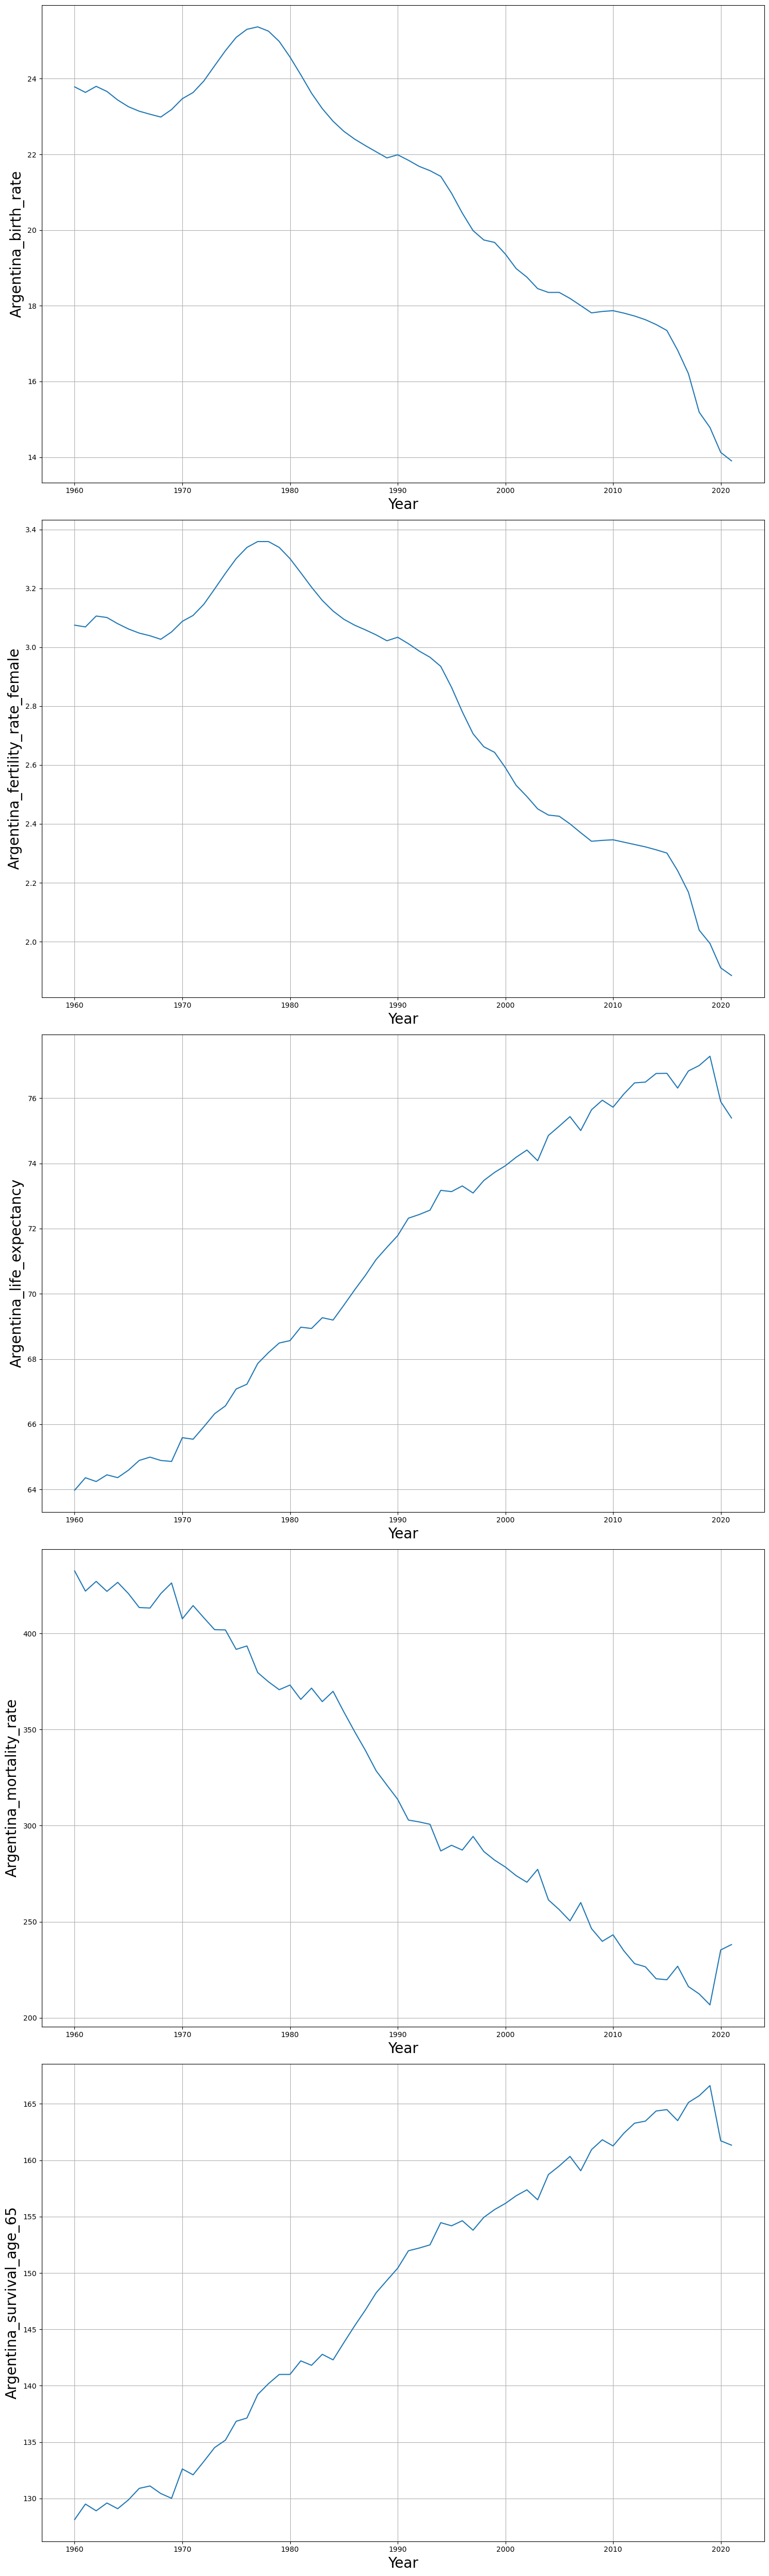

In [91]:
plot_series(df_exog_argentina)

#### Plot China series

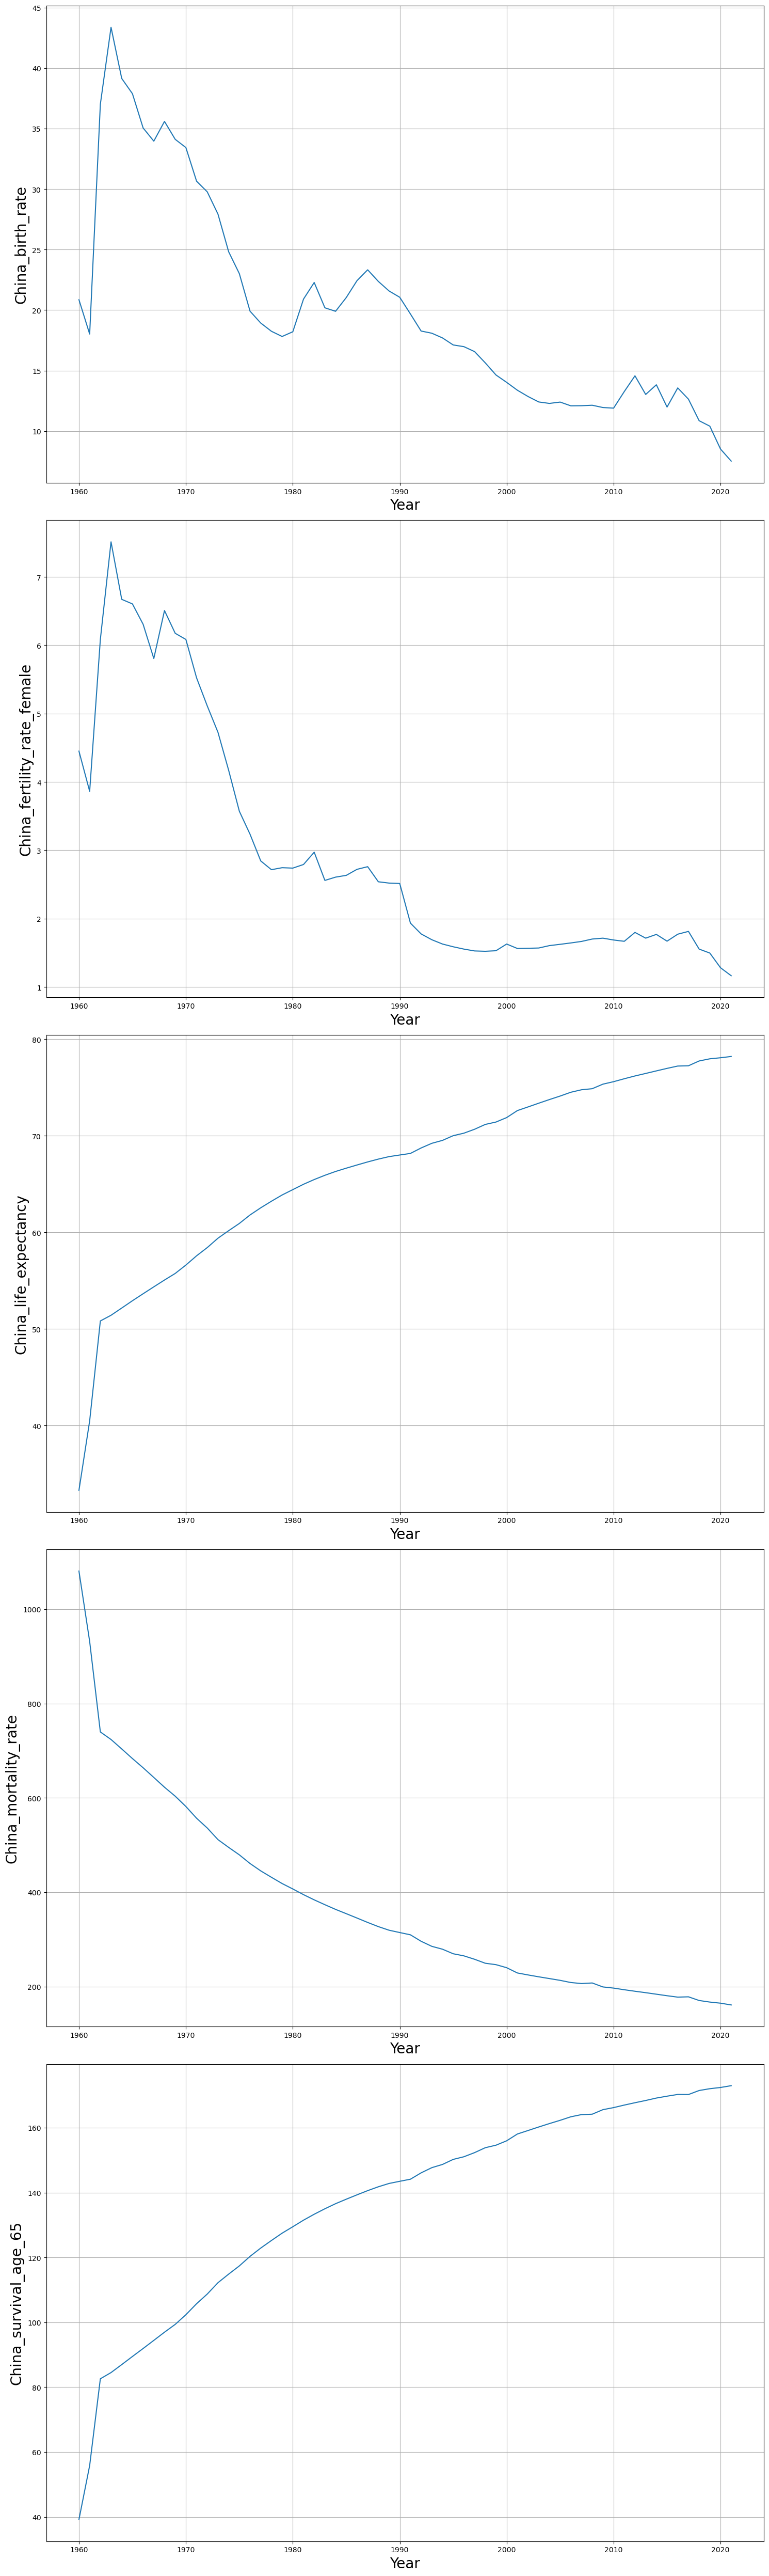

In [92]:
plot_series(df_exog_china)

#### Plot France time series

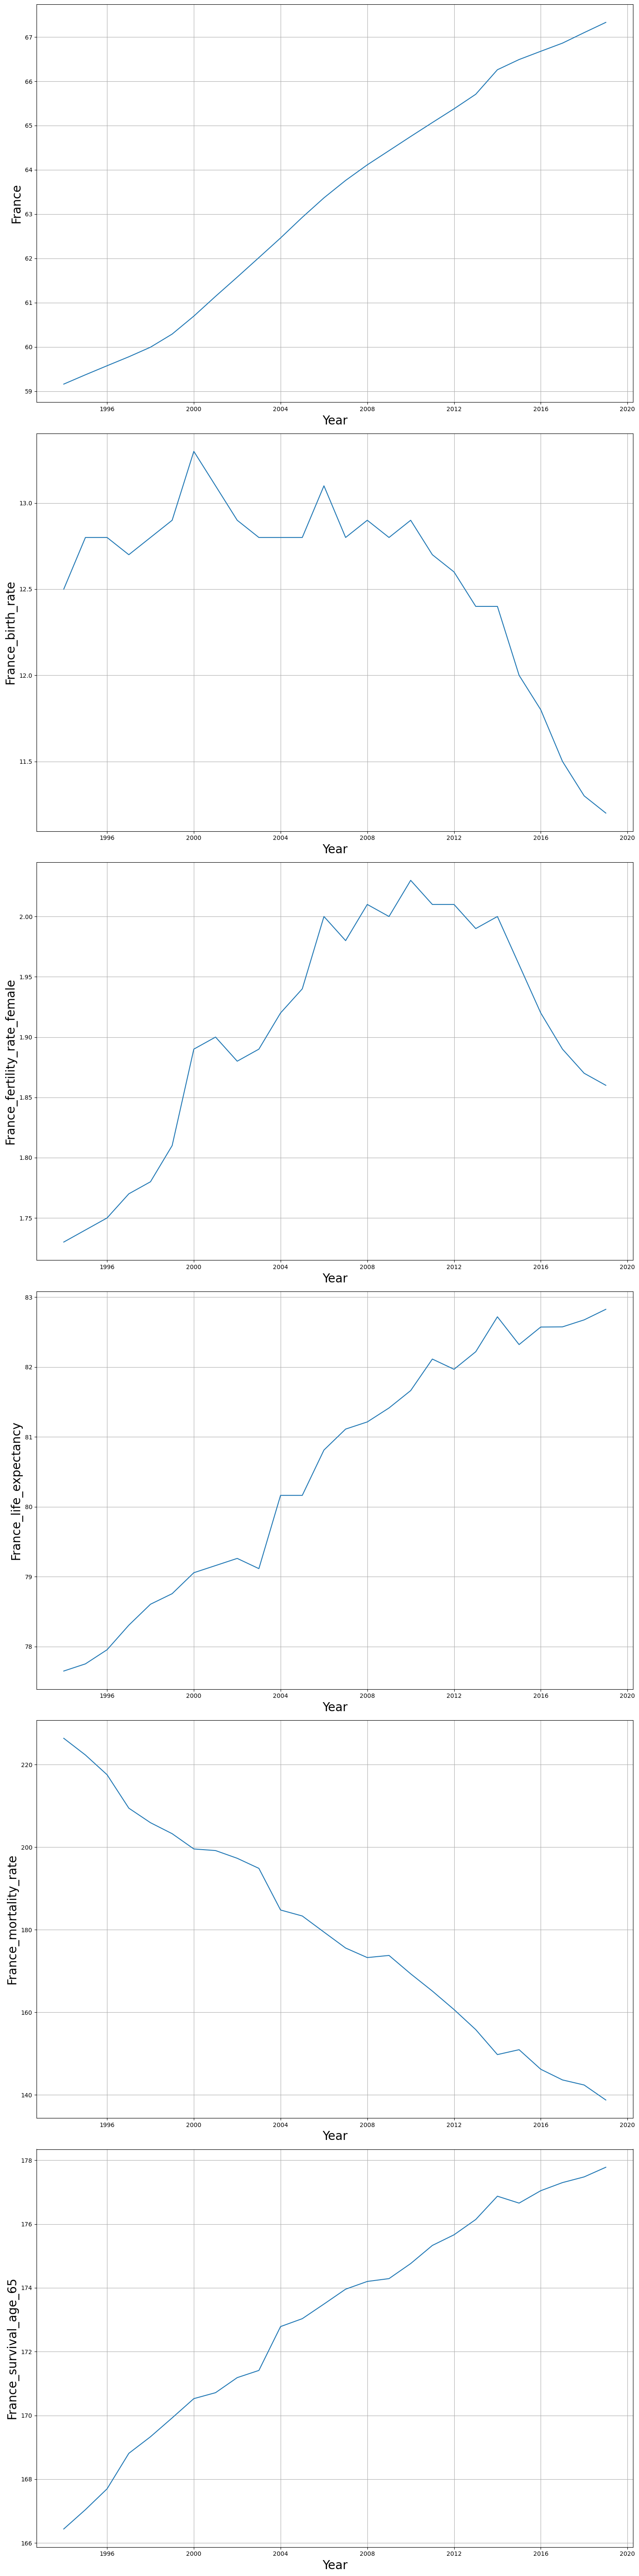

In [56]:
plot_series(df_france)

#### Plot New Zealand time series

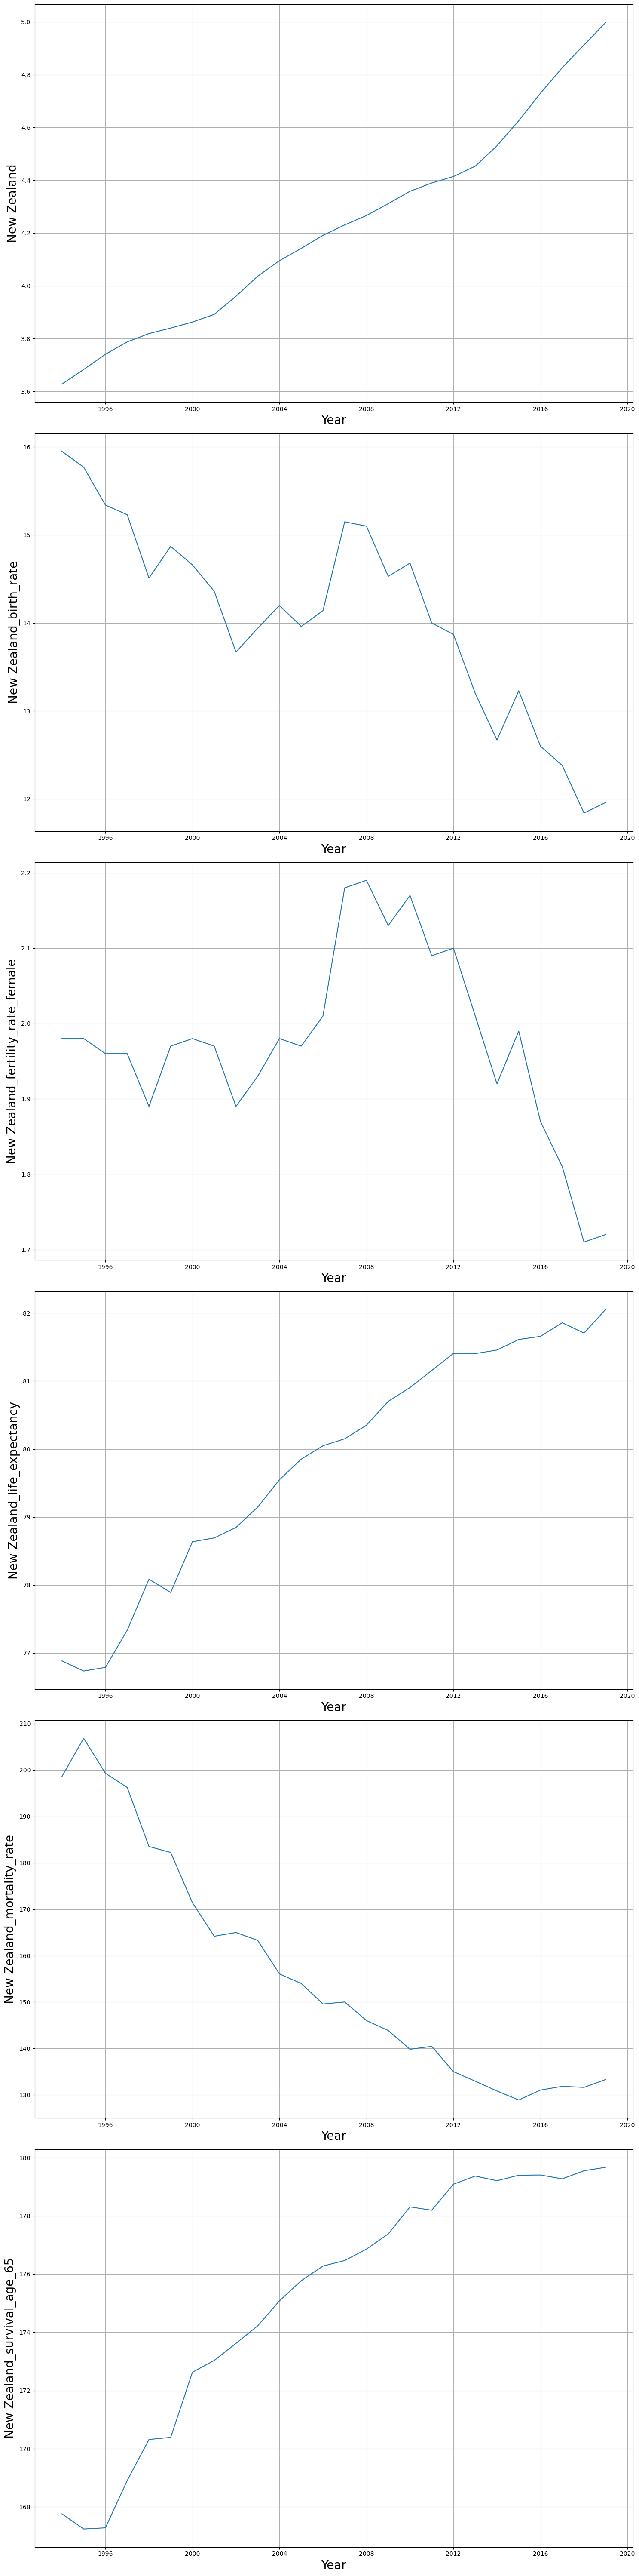

In [57]:
plot_series(df_new_zealand)

#### Plot Norway time series

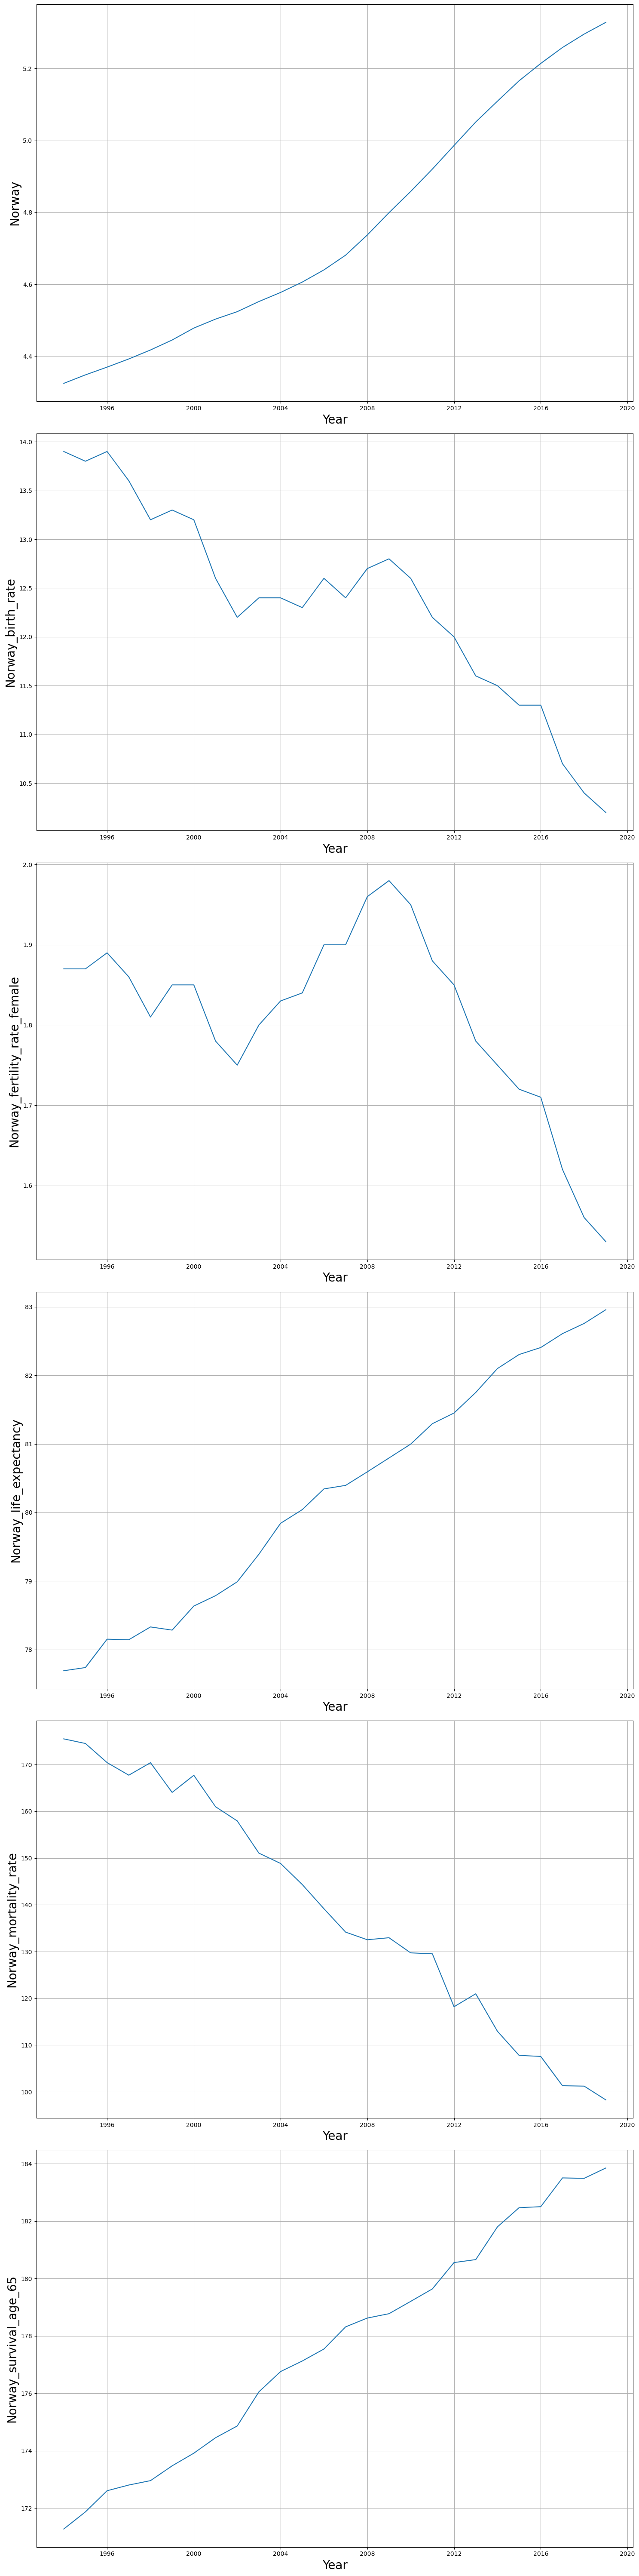

In [58]:
plot_series(df_norway)

#### Plot United States time series

#### Make the population time series stationnary

To do we will take first difference and apply a ADF test to assess the stationary of the time series.

If after taking the first difference, the time series remain non-stationary we wiil take the second difference

In [59]:
annualy_pop_data_1st_diff = annualy_pop_data.diff()
annualy_pop_data_1st_diff.dropna(inplace=True)

#### Apply ADF Test

In [60]:
print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL ARGENTINA")
print("______________________________")
adf_test(annualy_pop_data_1st_diff["Argentina"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL CHINA")
print("______________________________")
adf_test(annualy_pop_data_1st_diff["China"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL FRANCE")
print("______________________________")
adf_test(annualy_pop_data_1st_diff["France"])

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL NEW ZEALAND")
print("______________________________")
adf_test(annualy_pop_data_1st_diff["New Zealand"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL NORWAY")
print("______________________________")
adf_test(annualy_pop_data_1st_diff["Norway"])
print("")

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL ARGENTINA
______________________________
p_value:  0.17687664343273202
Fail to reject the null hypothesis. The time series may be non-stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL CHINA
______________________________
p_value:  0.5953247770196075
Fail to reject the null hypothesis. The time series may be non-stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL FRANCE
______________________________
p_value:  0.30616041091948926
Fail to reject the null hypothesis. The time series may be non-stationary.
______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL NEW ZEALAND
______________________________
p_value:  0.025700785090353617
Reject the null hypothesis. The time series is likely stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL NORWAY
______________________________
p_value:  0.9945557633655678
Fail to re

#### Plot the time series after taking the first difference

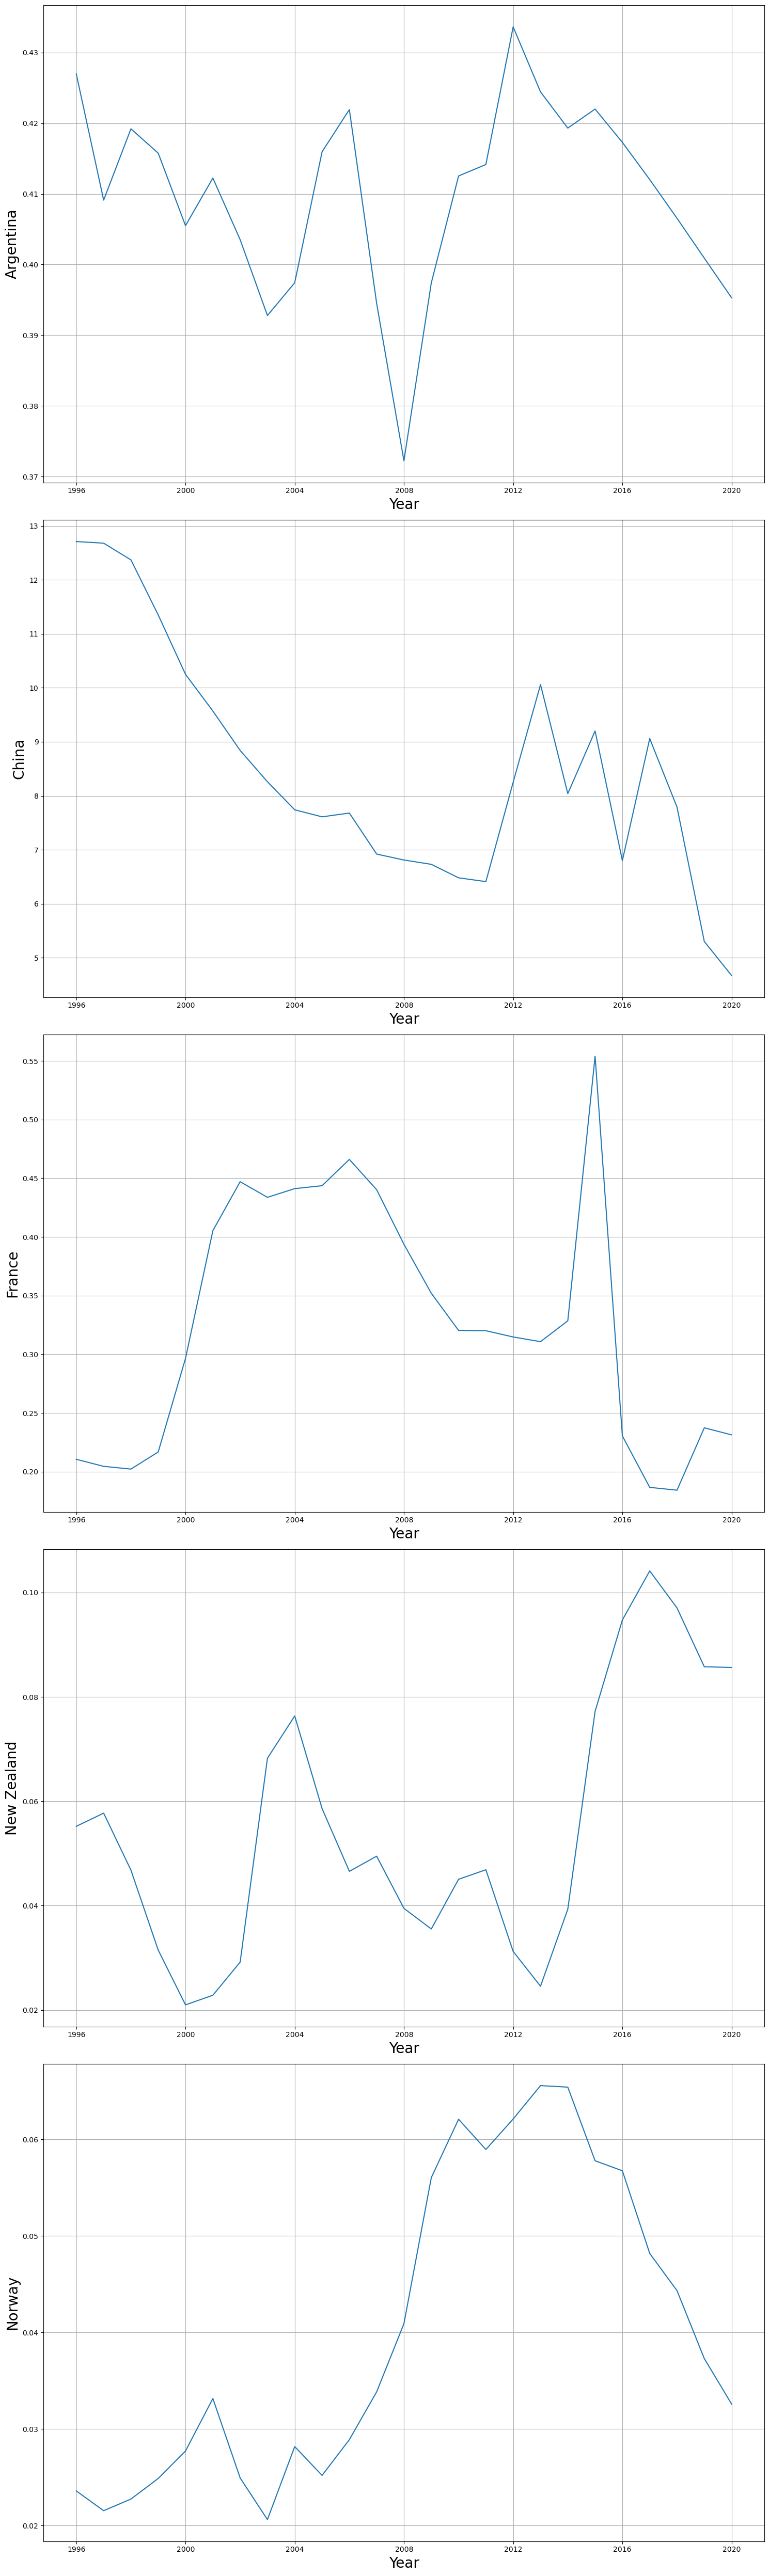

In [61]:
plot_series(annualy_pop_data_1st_diff[["Argentina", "China", "France", "New Zealand", "Norway"]])

#### Take the second difference

In [62]:
annualy_pop_data_2nd_diff = annualy_pop_data.diff().diff()
annualy_pop_data_2nd_diff.dropna(inplace=True)

In [63]:
print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL ARGENTINA")
print("______________________________")
adf_test(annualy_pop_data_2nd_diff["Argentina"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL CHINA")
print("______________________________")
adf_test(annualy_pop_data_2nd_diff["China"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL FRANCE")
print("______________________________")
adf_test(annualy_pop_data_2nd_diff["France"])

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL NEW ZEALAND")
print("______________________________")
adf_test(annualy_pop_data_2nd_diff["New Zealand"])
print("")

print("______________________________")
print("REGRESSION : CONSTANT AND TREND")
print("ANNUAL NORWAY")
print("______________________________")
adf_test(annualy_pop_data_2nd_diff["Norway"])
print("")

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL ARGENTINA
______________________________
p_value:  0.0007011574951569022
Reject the null hypothesis. The time series is likely stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL CHINA
______________________________
p_value:  6.317470172299791e-06
Reject the null hypothesis. The time series is likely stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL FRANCE
______________________________
p_value:  6.782738556279829e-06
Reject the null hypothesis. The time series is likely stationary.
______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL NEW ZEALAND
______________________________
p_value:  0.6676823935778743
Fail to reject the null hypothesis. The time series may be non-stationary.

______________________________
REGRESSION : CONSTANT AND TREND
ANNUAL NORWAY
______________________________
p_value:  0.05025605680370801
Fail to reject the nul

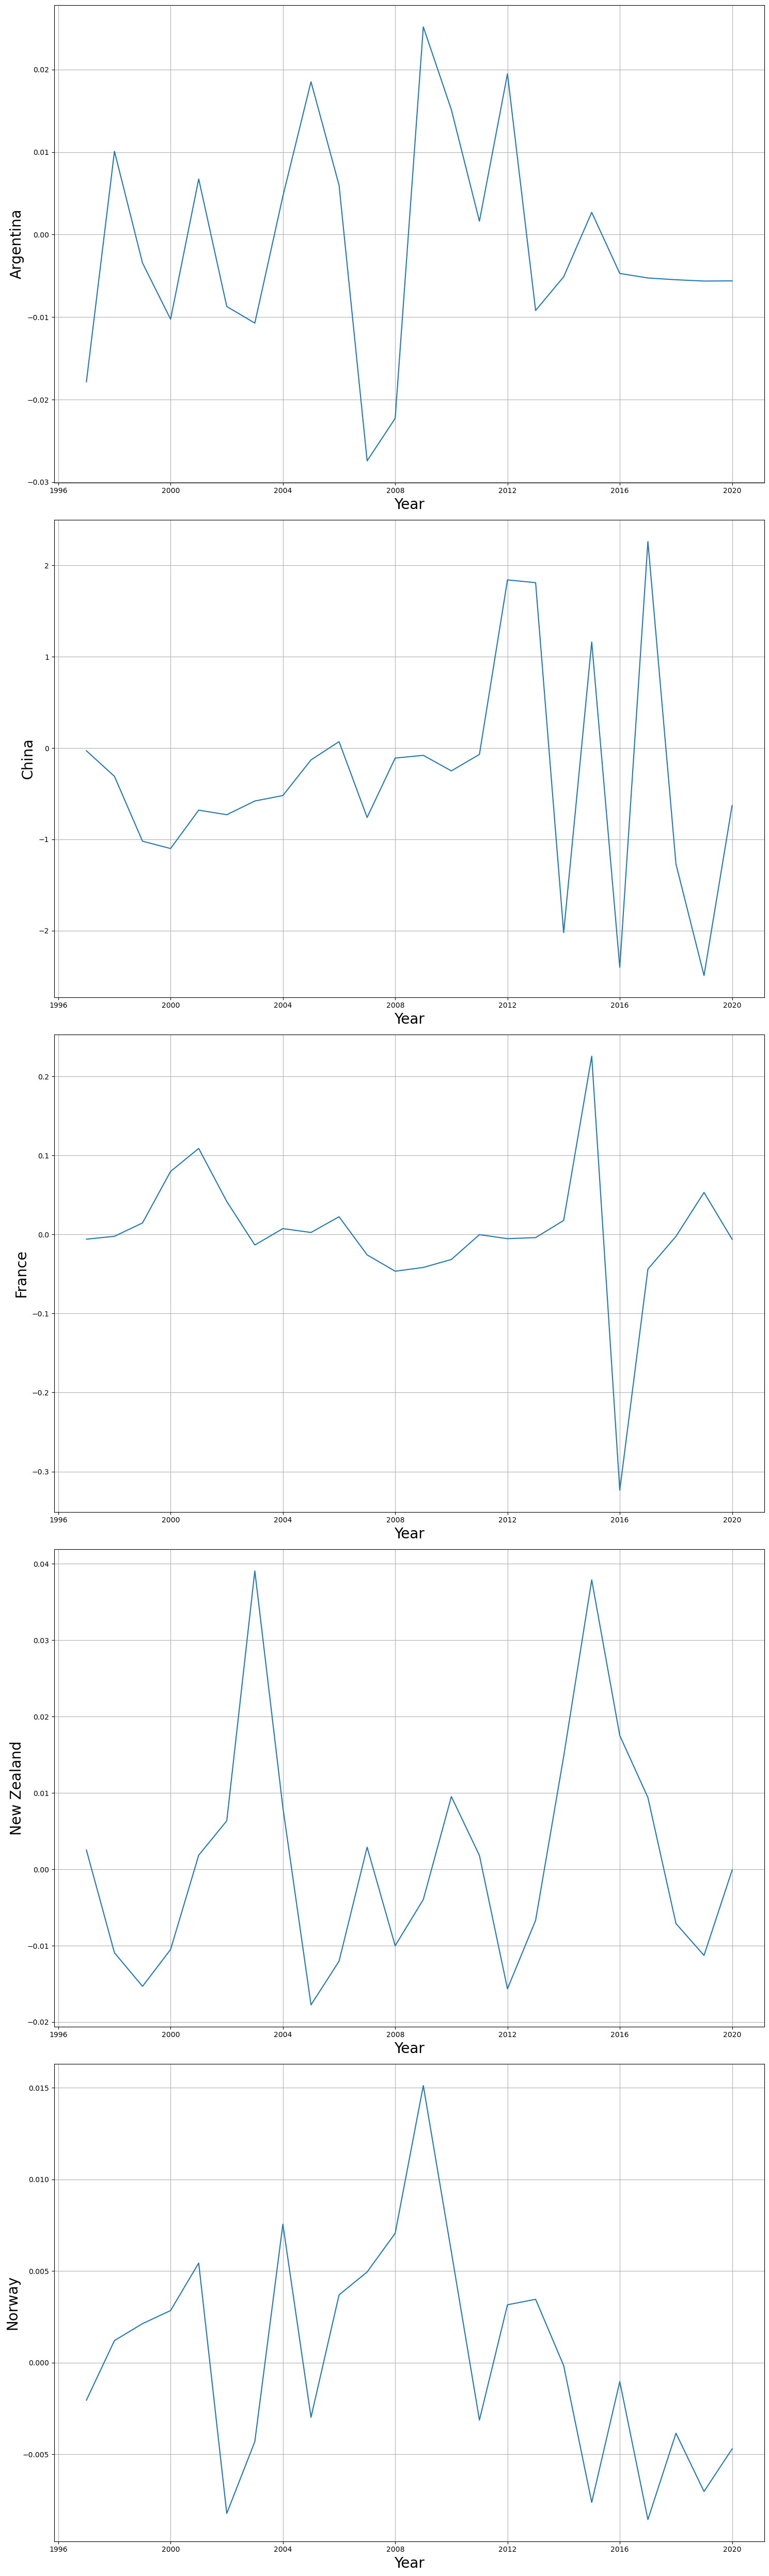

In [64]:
plot_series(annualy_pop_data_2nd_diff[["Argentina", "China", "France", "New Zealand", "Norway"]])

After taking the second difference, our time series seems to be stationary except for Norway, but the p-value (0.052) so we can consider this time series is stationary

In conclusion we will take the following differenciated order:

**1st Diff**
- New Zealand
- United States

**2dn Diff**
- Argentina
- China
- France

#### Apply ARIMAX model


#### Focus on China

#### Select the order of ARIMA

To select the order of ARIMAX model, first we will indentify the best order using ACF and PACF plot.

Then we will fit ARIMA thanks to the auto-arima library

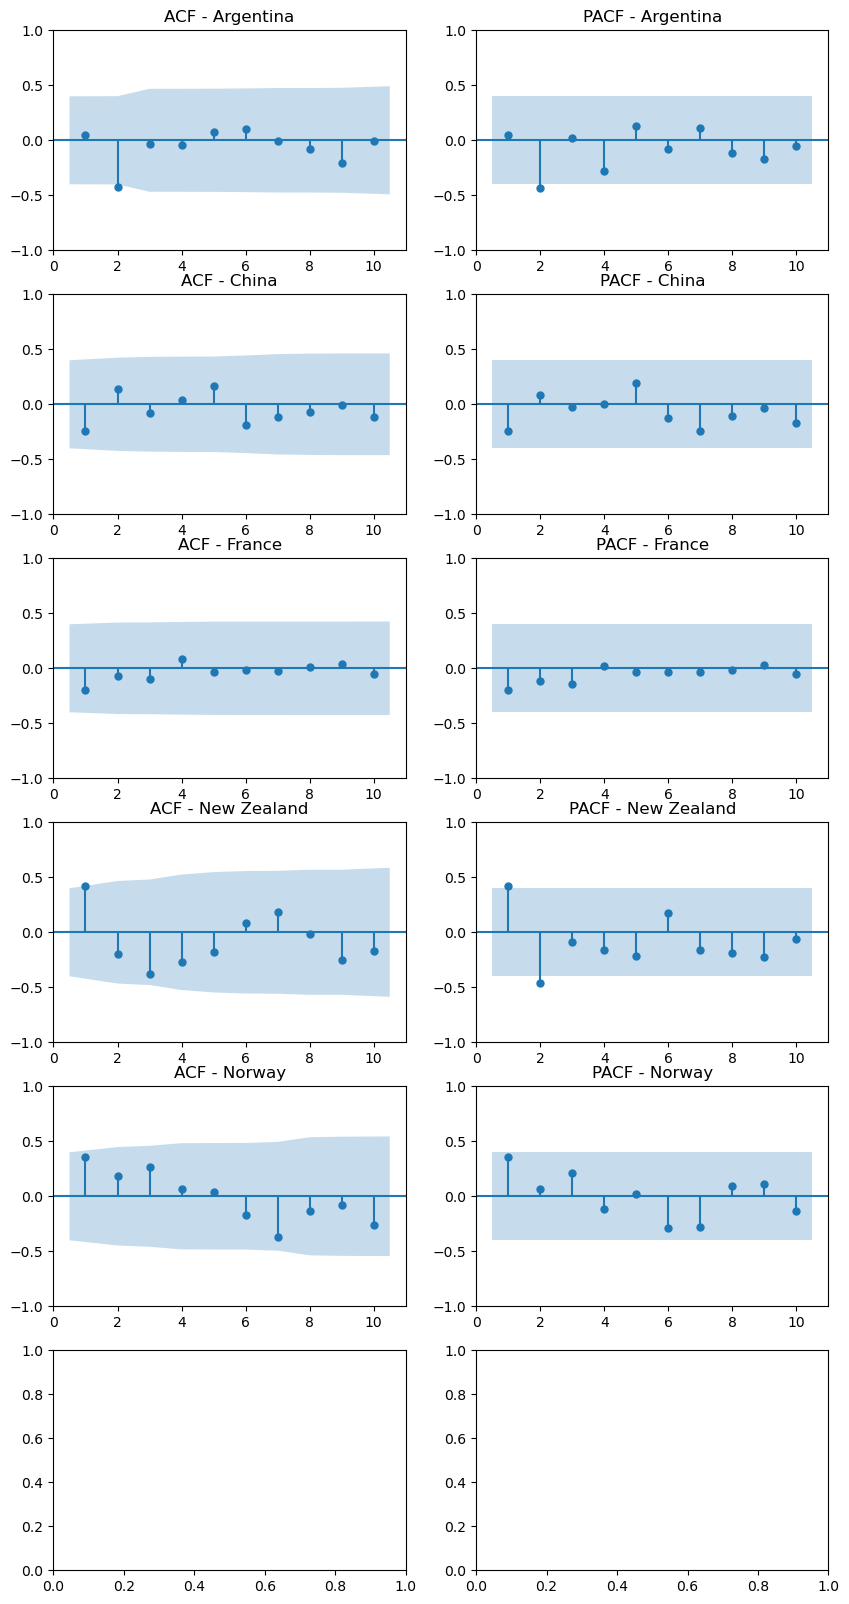

In [65]:
plot_acf_pacf_non_seasonal(annualy_pop_data_2nd_diff[["Argentina", "China", "France", "New Zealand", "Norway"]])

Interpretation

### Focus on China

#### Select the best order

In [66]:
model_arima = auto_arima(annualy_pop_data_2nd_diff["China"], # data
                           seasonal=False, # is the time series seasonal
                           d=2, # non seasonal difference order
                           start_p=1, # initial guess for p
                           start_q=1, # initial guess for q
                           max_p=4, # max value of p to test
                           max_q=4, # max value of q to test
                           information_criterion = 'aic',
                           trace = True,
                           error_action="ignore",
                           suppress_warnings=True
                           )

model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=121.601, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=104.085, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=119.618, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=96.223, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=97.427, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=94.233, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=102.115, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=95.437, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(2, 2, 0)   Log Likelihood                 -44.116
Date:                Sun, 12 Nov 2023   AIC                             94.233
Time:                        01:42:51   BIC                             97.506
Sample:                    12-31-1996   HQIC                            95.004
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3065      0.332     -3.939      0.000      -1.957      -0.656
ar.L2         -0.6468      0.332     -1.949      0.051      -1.297       0.004
sigma2         2.9398      0.576      5.102      0.000       1.810       4.069
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 9.72
Prob(Q):                              0.43   Prob(JB):                         0.01
Heteroskedasticity (H):              33.96   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Check the residuals of the model

###########################################
Check residuals of ARIMA for CHINA
###########################################

Mean of Residuals: -0.05268491898061863
We fail to reject H0: The residuals are not independently distributed.
No significant serial correlation in residuals.


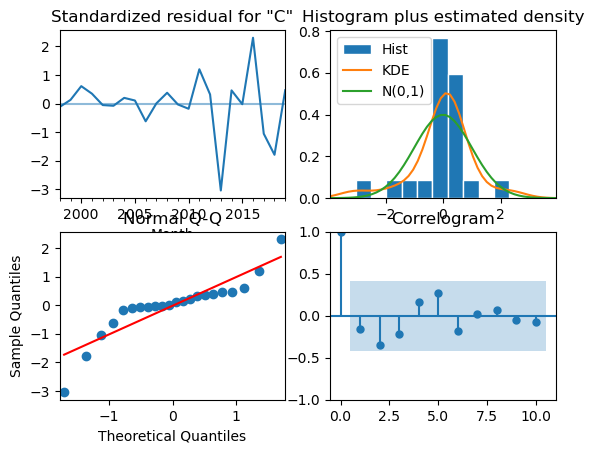

lb_stat  lb_pvalue
1  0.665721   0.414547
2  4.087133   0.129566
3  5.516987   0.137626

In [67]:
print("###########################################")
print("Check residuals of ARIMA for CHINA")
print("###########################################\n")
check_corr_resid(annualy_pop_data_2nd_diff["China"], (2,2,0))

#### Fitting ARIMAX model

The ARMAX model orders are : (2,2,0)

In [68]:
exog_df_china = df_china.iloc[:,1:]
exog_df_china = exog_df_china.apply(pd.to_numeric, errors='coerce')

In [69]:
df_exog_china = df_exog_china.apply(pd.to_numeric, errors='coerce')
print(df_exog_china.dtypes)

NaT
China_birth_rate               float64
China_fertility_rate_female    float64
China_life_expectancy          float64
China_mortality_rate           float64
China_survival_age_65          float64
dtype: object


In [115]:
model = ARIMA(df_china["China"], order=(2, 2, 0), exog=exog_df_china)
results = model.fit()
# Provide exogenous values for out-of-sample forecasting
forecast_steps = 5
exog_forecast = df_exog_china.tail(forecast_steps)

# Perform out-of-sample forecasting
forecast = results.get_forecast(steps=forecast_steps, exog=exog_forecast)

# Get the mean forecast
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(mean_forecast)

2020-01-01    1416.061563
2021-01-01    1417.427705
2022-01-01    1419.962432
2023-01-01    1421.436108
2024-01-01    1423.840511
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [116]:
data_pred = pd.concat([annualy_pop_data["China"], pd.DataFrame(mean_forecast)], axis=1)
data_pred['temp'] = data_pred[['China', 'predicted_mean']].sum(axis=1)
data_pred = data_pred.drop(['China', 'predicted_mean'], axis=1).rename(columns={'temp': 'China'})

#### Plot forecast

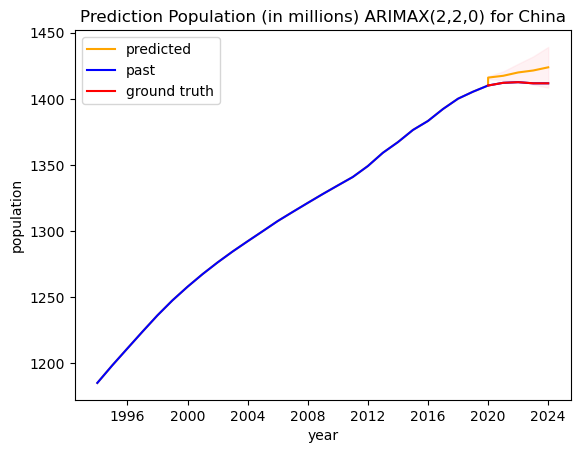

In [117]:
plt.figure()

plt.plot(data_pred.index, data_pred["China"], label='predicted', color="orange")

plt.plot(annualy_pop_data_raw["China"].index, annualy_pop_data_raw["China"], label='past', color='blue')

plt.plot(annualy_pop_data_covid.index, annualy_pop_data_covid["China"], color='red', label='ground truth')

plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:,0], confidence_intervals.iloc[:,1], alpha=0.2, color='pink')

plt.title("Prediction Population (in millions) ARIMAX(2,2,0) for China")

plt.xlabel("year")
plt.ylabel("population")

plt.legend()
plt.show()

#### Model evaluation

To evaluate the performance of the ARIMA we will apply the MSE


$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

where:
* $n$ is the number of observations,
* $y_i$ is the actual value for the $i$-th observation,
* $\hat{y}_i$ is the predicted value for the $i$-th observation.

In [118]:
mse_df = pd.concat([annualy_pop_data_covid["China"].reset_index(drop=True), mean_forecast.reset_index(drop=True)], axis=1)

In [119]:
mse = np.mean((mse_df["China"] - mse_df["predicted_mean"])**2)
mse

71.63147529622185

### Let's forecast with ARIMA (without exogenous variables)

The final step is to apply a ARIMA model on annual China population in order to compare the performance of ARIMAX vs. ARIMA model. This allow us to compare the importance of exogenous variables for forecasting population when extreme event occur such as COVID.

To do so we will fit a ARMA model with the same order than the ARMAX model

Hence the orders are : ARMA(2,2,0)

In [110]:
model = ARIMA(df_china["China"], order=(2, 2, 0))
results = model.fit()
forecast = results.get_forecast(steps=5)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(mean_forecast)

2020-01-01    1414.396849
2021-01-01    1418.646897
2022-01-01    1422.844233
2023-01-01    1427.036263
2024-01-01    1431.219883
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [111]:
data_pred = pd.concat([annualy_pop_data["China"], pd.DataFrame(mean_forecast)], axis=1)
data_pred['temp'] = data_pred[['China', 'predicted_mean']].sum(axis=1)
data_pred = data_pred.drop(['China', 'predicted_mean'], axis=1).rename(columns={'temp': 'China'})

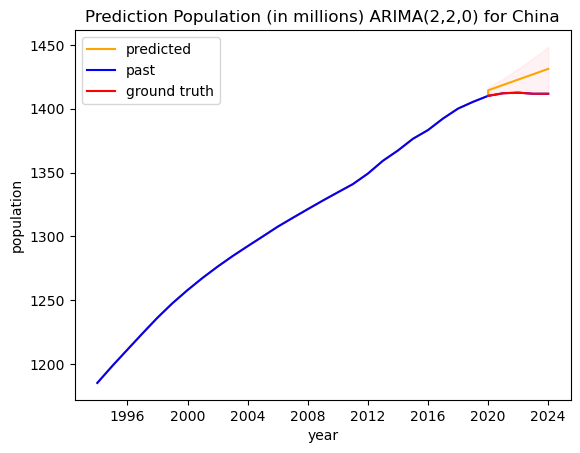

In [112]:
plt.figure()

plt.plot(data_pred.index, data_pred["China"], label='predicted', color="orange")

plt.plot(annualy_pop_data_raw["China"].index, annualy_pop_data_raw["China"], label='past', color='blue')

plt.plot(annualy_pop_data_covid.index, annualy_pop_data_covid["China"], color='red', label='ground truth')

plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:,0], confidence_intervals.iloc[:,1], alpha=0.2, color='pink')

plt.title("Prediction Population (in millions) ARIMA(2,2,0) for China")

plt.xlabel("year")
plt.ylabel("population")

plt.legend()
plt.show()

#### Model Evaluation

In [113]:
mse_df = pd.concat([annualy_pop_data_covid["China"].reset_index(drop=True), mean_forecast.reset_index(drop=True)], axis=1)

In [114]:
mse = np.mean((mse_df["China"] - mse_df["predicted_mean"])**2)
mse

155.78520977455202

###  Focus on World population

Text(0.5, 1.0, 'Word population in Billions')

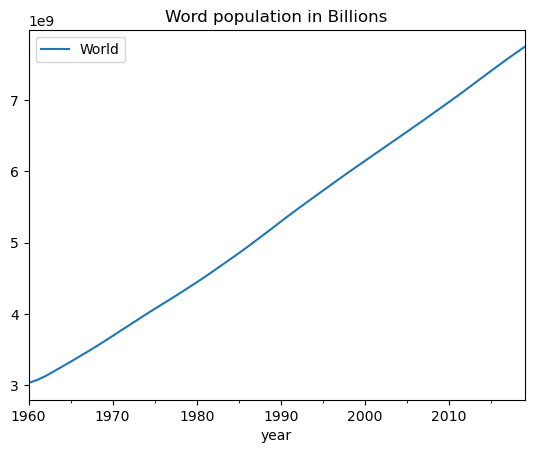

In [75]:
annualy_world_population.plot()
plt.title("Word population in Billions")

### Transform this series as stationary series

Text(0.5, 1.0, 'First Difference')

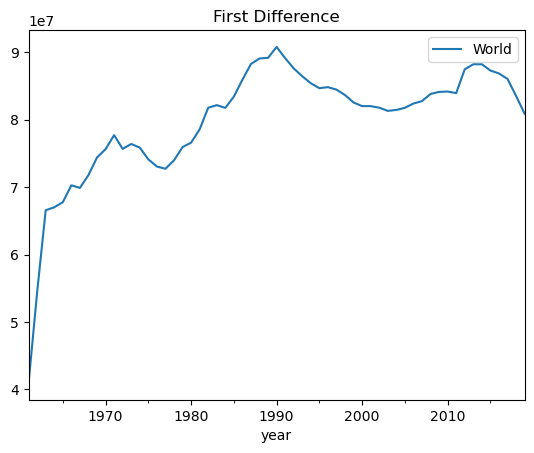

In [76]:
annualy_world_population_1_diff = annualy_world_population.diff().dropna()
annualy_world_population_1_diff.plot()
plt.title("First Difference")

In [77]:
adf_test(annualy_world_population_1_diff)

p_value:  0.3524493375695443
Fail to reject the null hypothesis. The time series may be non-stationary.


Text(0.5, 1.0, 'Second difference')

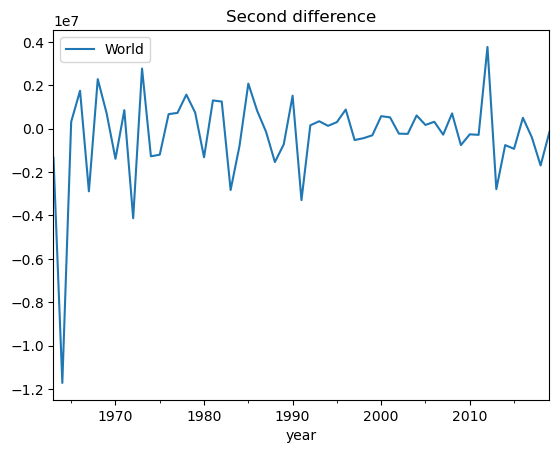

In [78]:
annualy_world_population_2_diff = annualy_world_population_1_diff.diff().diff().dropna()
annualy_world_population_2_diff.plot()
plt.title("Second difference")

In [79]:
adf_test(annualy_world_population_2_diff)

p_value:  6.32064599732671e-15
Reject the null hypothesis. The time series is likely stationary.


#### Select order of ARIMA model

In [80]:
model_arima = auto_arima(annualy_world_population_2_diff, # data
                           seasonal=False, # is the time series seasonal
                           d=2, # non seasonal difference order
                           start_p=1, # initial guess for p
                           start_q=1, # initial guess for q
                           max_p=4, # max value of p to test
                           max_q=4, # max value of q to test
                           information_criterion = 'aic',
                           trace = True,
                           error_action="ignore",
                           suppress_warnings=True
                           )

model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1798.321, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1866.423, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1842.157, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1817.873, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1864.546, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1792.045, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1815.005, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1788.160, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1813.273, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1786.827, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1804.101, Time=0.03 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=1795.658, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(4,2,1)(0,0,0)[0] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(4, 2, 1)   Log Likelihood                -886.413
Date:                Sun, 12 Nov 2023   AIC                           1786.827
Time:                        01:42:53   BIC                           1800.878
Sample:                    01-01-1963   HQIC                          1792.260
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.451e+05   8.44e+04     -1.720      0.085    -3.1e+05    2.02e+04
ar.L1         -1.0511      0.100    -10.473      0.000      -1.248      -0.854
ar.L2         -1.0737      0.180     -5.963      0.000      -1.427      -0.721
ar.L3         -0.7798      0.106     -7.375      0.000      -0.987      -0.573
ar.L4         -0.4535      0.093     -4.862      0.000      -0.636      -0.271
ma.L1         -0.8144      0.136     -5.989      0.000      -1.081      -0.548
sigma2      3.981e+12      0.007   5.98e+14      0.000    3.98e+12    3.98e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                13.96
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+30. Standard errors may be unstable.
"""

#### Fitting ARIMA model

The ARIMA model orders are : (4,2,1)

In [81]:
annualy_world_population = annualy_world_population.apply(pd.to_numeric, errors='coerce')
print(annualy_world_population.dtypes)

World    float64
dtype: object


In [82]:
model = ARIMA(annualy_world_population, order=(4, 2, 1))
results = model.fit()
forecast = results.get_forecast(steps=3)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(mean_forecast)

2020-01-01    7.823624e+09
2021-01-01    7.904580e+09
2022-01-01    7.985538e+09
Freq: AS-JAN, Name: predicted_mean, dtype: float64


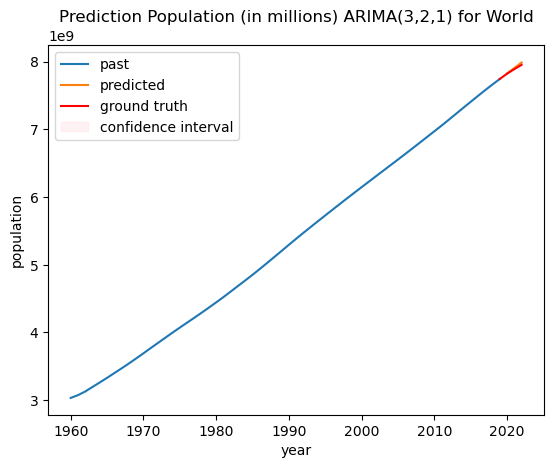

In [83]:
plt.figure()

plt.plot(annualy_world_population.index, annualy_world_population, label='past')

plt.plot(mean_forecast.index, mean_forecast, label='predicted')

plt.plot(annualy_world_population_covid.index, annualy_world_population_covid, color='red', label='ground truth')

plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:,0], confidence_intervals.iloc[:,1], alpha=0.2, color='pink', label="confidence interval")

plt.title("Prediction Population (in millions) ARIMA(3,2,1) for World")

plt.xlabel("year")
plt.ylabel("population")

plt.legend()
plt.show()

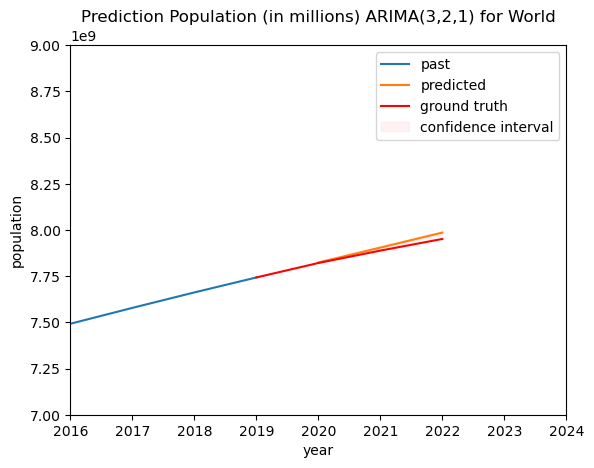

In [90]:
from datetime import datetime

plt.figure()

plt.plot(annualy_world_population.index, annualy_world_population, label='past')

plt.plot(mean_forecast.index, mean_forecast, label='predicted')

plt.plot(annualy_world_population_covid.index, annualy_world_population_covid, color='red', label='ground truth')

plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:,0], confidence_intervals.iloc[:,1], alpha=0.2, color='pink', label="confidence interval")

plt.title("Prediction Population (in millions) ARIMA(3,2,1) for World")

plt.xlabel("year")
plt.ylabel("population")

plt.xlim([2018, 2024])
plt.ylim([7e9, 9e9])

plt.xlim([datetime.strptime("2016-01-01", "%Y-%m-%d"), datetime.strptime("2024-01-01", "%Y-%m-%d")])

plt.legend()
plt.show()



In [85]:
annualy_world_population_covid[1:]

World
year                    
2020-01-01  7820963775.0
2021-01-01  7888161297.0
2022-01-01  7951149546.0

In [86]:
mse_df = pd.concat([annualy_world_population_covid[1:].reset_index(drop=True), mean_forecast.reset_index(drop=True)], axis=1)



In [93]:
# Define the datetime index
datetime_index = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01'])

# Set the datetime index to the DataFrame
mse_df = mse_df.set_index(datetime_index)

In [94]:
mse_df

World  predicted_mean
2020-01-01  7820963775.0    7.823624e+09
2021-01-01  7888161297.0    7.904580e+09
2022-01-01  7951149546.0    7.985538e+09

#### Model evaluation

In [88]:
mse = np.mean((mse_df['World'] - mse_df["predicted_mean"])**2)
mse

486402302130827.7